In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
import astropy.constants as const
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.modeling.models import BlackBody
from scipy import stats, interpolate
import astrotools.orbitparams as orb
import astrotools.generateExoplanetTable as genTab
import astrotools.interpolate_stellar_spectra as interpspec
import pysynphot
import pickle
import json
import starry as st
import copy
import os
import glob
from collections import OrderedDict
st.config.lazy = False
st.config.quiet = True
from jwst_backgrounds import jbt
import pandeia.engine
from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.instrument_factory import InstrumentFactory
from pandeia.engine.perform_calculation import perform_calculation


print("Pandeia engine versions:", pandeia.engine.pandeia_version())

Pandeia Engine version:  3.0
Pandeia RefData version:  3.0
Synphot Data:  /home/hannah/programs/grp/redcat/trds
Pandeia engine versions: None


## Some initial settings

In [2]:
default_filter    = 'f1500w'
default_subarray  = 'sub256'
pull_default_dict = True # needs to be true if you want to pull a new default dictionary from pandeia
make_new_bkg      = True # should be true if working with different stars; otherwise set to False for speed
miri_arrays_descending = ['full', 'brightsky', 'sub256', 'sub128', 'sub64']

In [3]:
def get_bkg(targ, ref_wave, make_new_bkg=False, savepath='../sample/background/', verbose=False):
    """
    Code to retrieve sky background from the jwst backgrounds database based on system coordinates
    JWST backgrounds: https://jwst-docs.stsci.edu/jwst-general-support/jwst-background-model
    
    Inputs:
    targ          -- dictionary of target; must include RA and Dec of system as strings
    ref_wave      -- reference wavelength for jbt to return 
    make_new_bkg  -- default=True; otherwise you can load up the last background called, 
                                   use if only working with one system
                                   
    Returns:
    background    -- list of two lists containing wavelength (um) and background counts (mJy/sr)
    """
    
    print('Computing background')

    sys_coords = targ['rastr']+' '+targ['decstr']
    sys_name   = targ['hostname'].replace(" ", "")

    def bkg():
    
        # make astropy coordinates object
        c = SkyCoord(sys_coords, unit=(u.hourangle, u.deg))

        # use jwst backgrounds to compute background at this point
        bg = jbt.background(c.ra.deg, c.dec.deg, ref_wave)

        # background is computed for many days; choose one
        ndays = bg.bkg_data['calendar'].size
        assert ndays > 0  # make sure object is visible at some point in the year; if not check coords
        middleday = bg.bkg_data['calendar'][int(ndays / 2)] # picking the middle visible date; somewhat arbitrary!
        middleday_indx = np.argwhere(bg.bkg_data['calendar'] == middleday)[0][0]

        tot_bkg = bg.bkg_data['total_bg'][middleday_indx]
        wav_bkg = bg.bkg_data['wave_array']

        # background is [wavelength, total_background] in [micron, mJy/sr]
        background = [list(np.array(wav_bkg)), list(np.array(tot_bkg))]

        ascii.write(background, savepath+f"{sys_name}_background.txt", overwrite=True)
        
        print('Returning background')
        return background
    
    if make_new_bkg: background = bkg()

    else: 
        try: 
            print('Using existing background')
            background = ascii.read(savepath+f"{sys_name}_background.txt")
            background = [list(background['col0']), list(background['col1'])]
        except:
            background = bkg()
    
    return background

In [4]:
def make_miri_dict(filter, subarray, targ, pull_default_dict=False, scene_spec='phoenix', key='m5v', input_spec=[], savepath='./', verbose=False):
    """
    Code to make the initial miri dictionally for imaging_ts
    
    Inputs:
    filter            -- which photometric filter to use (e.g., f1500w)
    subarray          -- which subarray readout ot use (e.g., sub256)
    targ              -- 
    sys_coords        -- string of the coordinates of the system in RA Dec; e.g. "23h06m30.33s -05d02m36.46s";
                         to be passed to get_bkg function
    pull_default_dict -- default=True; can re-use a saved one but this doesn't save much time.
    scene_spec        -- default='phoenix' this default requires the "key" argument
                         can also be 'input' which then requires the "input_spec" argument to not be empty
    key               -- goes with scene_spec;  (e.g., 'm0v, m5v')
    input_spec        -- list of 2 arrays, or ndarray; Wavelength (μm) and Flux (mJy) arrays of the SED to use;
                         In an ndarray, wavelength is the 0th index, and flux the 1st index.
    """

    if verbose: print('Creating MIRI dictionary')

    def pull_dict_from_stsci():
        miri_imaging_ts = build_default_calc('jwst', 'miri', 'imaging_ts')

        # Serializing json
        json_object = json.dumps(miri_imaging_ts, indent=4)

        # Writing to sample.json
        with open("miri_imaging_ts.json", "w") as outfile:
            outfile.write(json_object)

        return miri_imaging_ts

    # grab default imaging ts dictionary (I think this only works online?)
    if pull_default_dict: miri_imaging_ts = pull_default_dict()
    else: 
        try:
            with open("miri_imaging_ts.json", "r") as f:
                miri_imaging_ts = json.load(f)
        except(FileNotFoundError): miri_imaging_ts = pull_default_dict()
            
    if   filter == 'f1500w': ref_wave = 15.0 * u.micron
    elif filter == 'f1800w': ref_wave = 18.0 * u.micron
    elif filter == 'f1280w': ref_wave = 12.8 * u.micron
    elif filter == 'f2100w': ref_wave = 21.0 * u.micron
    elif filter == 'f2550w': ref_wave = 25.5 * u.micron
    elif filter == 'f1130w': ref_wave = 11.3 * u.micron
    elif filter == 'f1000w': ref_wave = 10.0 * u.micron
    elif filter == 'f770w' : ref_wave =  7.7 * u.micron
    elif filter == 'f560w' : ref_wave =  5.6 * u.micron
    else:
        print("ERROR: I do not seem to have that filter. Check please.")
        return {}
            
    # update with basic parameters
    miri_imaging_ts['configuration']['instrument']['filter'] = filter
    miri_imaging_ts['configuration']['detector']['subarray'] = subarray
       
    miri_imaging_ts['configuration']['detector']['ngroup']   = 2    
    miri_imaging_ts['configuration']['detector']['nint'] = 1 
    miri_imaging_ts['configuration']['detector']['nexp'] = 1
    miri_imaging_ts['configuration']['detector']['readout_pattern'] = 'fastr1'
    try: miri_imaging_ts['configuration'].pop('max_filter_leak')
    except(KeyError): pass

    miri_imaging_ts['scene'][0]['spectrum']['normalization'] = {}
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['type']          = 'photsys'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'vegamag'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['bandpass']      = '2mass,ks'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_flux']     = targ['sy_kmag']           # change this for different stars

    if scene_spec == 'phoenix': 
        miri_imaging_ts['scene'][0]['spectrum']['sed']['key']          = key
        miri_imaging_ts['scene'][0]['spectrum']['sed']['sed_type']     = 'phoenix'
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('unit')
        except(KeyError): pass
    elif scene_spec == 'input':
        miri_imaging_ts['scene'][0]['spectrum']['sed']['sed_type']     = 'input'
        miri_imaging_ts['scene'][0]['spectrum']['sed']['spectrum']     = input_spec
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('unit')
        except(KeyError): pass
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('key')
        except(KeyError): pass

    miri_imaging_ts['background'] = get_bkg(targ, ref_wave, verbose=verbose)
    miri_imaging_ts['background_level'] = 'high' # let's keep it conservative

    miri_imaging_ts['strategy']['aperture_size']  = 0.55            # values from Greene+ 2023 for T1-b
    miri_imaging_ts['strategy']['sky_annulus']    = [1.32, 2.8]     # assuming MIRI plate scale of 0.11"/pix

    if verbose: print('Returning MIRI dictionary')
    return miri_imaging_ts

In [5]:
def make_miri_calib_dict(miri_dict):

    print('Creating MIRI calibration dictionary')

    miri_imaging_ts_calibration = copy.deepcopy(miri_dict)

    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['sed_type']     = 'flat'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['unit']         = 'flam'
    try: miri_imaging_ts_calibration['scene'][0]['spectrum']['sed'].pop('key')
    except(KeyError): pass

    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['type']          = 'at_lambda'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_wave']     = 2
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_waveunit'] = 'um'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_flux']     = 1e-18
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'flam'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization'].pop('bandpass')
    

    print('Returning MIRI calibration dictionary')

    return miri_imaging_ts_calibration

In [6]:
# Creating a standard star
def make_star(targ):
    M_s  = targ['st_mass']
    R_s  = targ['st_rad']
    prot = 1

    star = st.Primary(
        st.Map(ydeg = 1, udeg = 2, nw = 1, amp = 1.0), 
        m    = M_s,
        r    = R_s, 
        prot = prot
    )

    return star

# creating a planet; 
# adapted from Mette's code
def make_planet(plnt, phase=0, t0=0, tidally_locked=True):

    planet  = st.kepler.Secondary(
        st.Map(ydeg = 5, nw = 1, amp = 5e-3),               
        m      = plnt['pl_bmasse'],                                
        r      = plnt['pl_rade'],                          
        porb   = plnt['pl_orbper'],                                                      
        prot   = plnt['pl_orbper'],                                       
        Omega  = 0,                                         
        ecc    = 0,                                                         
        w      = 90,                                  
        t0     = t0,                           
        theta0 = 180,                           
        inc    = plnt['pl_orbincl'],
        length_unit = u.Rearth,
        mass_unit   = u.Mearth

    )
    
    if tidally_locked:
        planet.map.spot(contrast = -1, radius = 60)
        
    return planet

In [7]:
def calc_FpFs(T_s, T_p, wavelength, R_s, R_p):
    
    ''' This function will take in the Temperature in Kelvin, 
    and the wavelength range that we are looking at,
    as well as the the radius of the star and the planet. '''
    
    bb_s = BlackBody(T_s, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    bb_p = BlackBody(T_p, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    
    Flux_ratio = bb_p(wavelength)/bb_s(wavelength) * (R_p/R_s)**2
        
    return Flux_ratio.decompose()

def calc_Tday(T_s, R_s, a, albedo=0.0, atmo='bare_rock'):
    # can be 'bare rock' or 'equilibrium'
    if   atmo == 'bare_rock': f = 2/3
    elif atmo == 'equilibrium': f = 1/4
    
    T_day = T_s * np.sqrt((R_s/a).decompose()) * (1 - albedo)**(1/4) * f**(1/4)
    
    return T_day

def get_all_model_spec(targ):
    plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
    print(targ['pl_name'], '-->', plnt_name)
    
    path = '../JWST_Terrestrials/'
    specpath = path+plnt_name+'/Spectra/'
    speclist = np.sort(os.listdir(specpath))
    
    all_spec = {}
    for specfile in speclist:
        model = ascii.read(specpath+specfile, data_start=3)
    
        wave = model['col2']
        Fp_Fs = model['col7']
        all_spec[specfile] = [wave, Fp_Fs]
        
    return all_spec
    
def grab_model_spec(targ, molecule='CO2', nbar=1):
    plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
    print(targ['pl_name'], '-->', plnt_name)
    
    path = '../JWST_Terrestrials/'
    if molecule==None: specfile = f'basaltic_noatm_TOA_flux_eclipse.dat'
    else: specfile = f'basaltic_{nbar}b_{molecule}_TOA_flux_eclipse.dat'
    specpath = path+plnt_name+'/Spectra/'+specfile
    #speclist = np.sort(os.listdir(specpath))
    
    model = ascii.read(specpath, data_start=3)
    
    wave = model['col2']
    fpfs = model['col7']
    
    return wave, fpfs
    
def calc_chi_sq(model, data, error):
    return np.sum(((model - data)/error)**2)

def calc_significance(chisq, dof):
    # this is a way of doing it without any 1 - *really tiny number* such that you don't get a result of inf. 
    # this website has some figures that helped me figure this out: http://work.thaslwanter.at/Stats/html/statsDistributions.html
    return stats.norm.isf((stats.chi2.sf(chisq, dof))/2.)


In [8]:
def do_it_right(targ, model, ngroups=2):
    starname = targ['hostname'].replace(' ', '')
    input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
    input_spec = ascii.read(input_spec_path)
    input_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])

    miri_imaging_ts = make_miri_dict('f1500w', 'sub256', targ, 
                                     scene_spec='input', input_spec=input_spec, 
                                     verbose=False)

    ngroups=2 # fix this for this method!!
    miri_imaging_ts['configuration']['detector']['ngroup'] = ngroups
    report = perform_calculation(miri_imaging_ts)

    # planet params
    tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                    Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose().value,
                    a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose().value,
                    i = targ['pl_orbincl']
                   ) # event duration

    instfac = InstrumentFactory(miri_imaging_ts['configuration'])
    rn = instfac.read_detector_pars()['rn']

    # timing of observations
    tframe  = report['information']['exposure_specification']['tframe'] * u.s
    tfrac   = 1.25
    tint    = tframe * ngroups                    # amount of time per integration
    treset  = 1*tframe                            # reset time between each integration is 1 frame time for MIRI
    #cadence = tint + treset                       # observing cadence = integrating time + reset time
    nint_in = np.floor((tdur/(tint + treset)).decompose())      # number of in-eclipse integrations

    inn = copy.deepcopy(report)
    
    # adding the planet to the star flux
    miri_imaging_ts_planet = copy.deepcopy(miri_imaging_ts) 
    f = interpolate.interp1d(model['wave'], model['fpfs'], fill_value='extrapolate')
    Fp_Fs = f(miri_imaging_ts_planet['scene'][0]['spectrum']['sed']['spectrum'][0])
    miri_imaging_ts_planet['scene'][0]['spectrum']['sed']['spectrum'][1] *= (1 + Fp_Fs) 
    out = perform_calculation(miri_imaging_ts_planet)

    nint_out = nint_in*tfrac
    extraction_area = report['scalar']['extraction_area'] # area in pixels

    #on source out versus in 
    exptime_per_int = tframe.value * (ngroups-1)

    on_source_in = tframe.value * (ngroups-1) * nint_in
    on_source_out = tframe.value * (ngroups-1) * nint_out

    curves_out = out['1d']
    curves_inn = inn['1d']

    #calculate rn 
    rn_var = rn**2.0

    #1d rn     = rn/pix * # of integrations   * #pixs
    rn_var_inn = rn_var * nint_in * extraction_area 
    rn_var_out = rn_var * nint_out * extraction_area 

    #extract fluxs
    extracted_flux_inn = curves_inn['extracted_flux'][1] * on_source_in 
    extracted_flux_out = curves_out['extracted_flux'][1] * on_source_out 

    #background + contamination extracted 
    bkg_flux_inn = curves_inn['extracted_bg_only'][1] * on_source_in 
    bkg_flux_out = curves_out['extracted_bg_only'][1] * on_source_out 

    #total nois 
    varin = (extracted_flux_inn + bkg_flux_inn + rn_var_inn)
    varout = (extracted_flux_out + bkg_flux_out + rn_var_out)

    result = {'photon_out_1d':extracted_flux_out, 'photon_in_1d':extracted_flux_inn, 
                        'var_in_1d':varin, 'var_out_1d': varout,'on_source_in':on_source_in, 
                    'on_source_out':on_source_out, 'rn[out,in]':[rn_var_out,rn_var_inn], 
                    'bkg[out,in]':[bkg_flux_out,bkg_flux_inn]}

    varin = result['var_in_1d']
    varout = result['var_out_1d']
    extracted_flux_out = result['photon_out_1d']
    extracted_flux_inn = result['photon_in_1d']

    photon_out_bin = extracted_flux_out
    photon_in_bin = extracted_flux_inn
    photon_in_bin = photon_in_bin[photon_out_bin>0]
    var_in_bin = varin
    var_in_bin = var_in_bin[photon_out_bin>0]
    var_out_bin = varout
    var_out_bin = var_out_bin[photon_out_bin>0]
    photon_out_bin = photon_out_bin[photon_out_bin>0]

    to = result['on_source_out']
    ti = result['on_source_in']

    var_tot = (to/ti/photon_out_bin)**2.0 * var_in_bin + (photon_in_bin*to/ti/photon_out_bin**2.0)**2.0 * var_out_bin
    error_spec = np.sqrt(var_tot)

    return error_spec.value


In [9]:
def process_target(targ, tfrac=1, tsettle=30*u.min, tcharge=1*u.hr, 
                   ndraws=1000, find_best_subarray=False,
                   Fp_Fs_from_model=False, Albedos=[],
                   stellar_spec='default', input_spec=[],
                   display_figure=True, save_figure=False, verbose=True):
    print(targ)

    try:
        filter = targ['filter']
        subarray = targ['subarray']
        nobs = targ['nobs']
        frac_fullwell = targ['frac_fullwell']
        
        print(f'***Using user-provided filter={filter}, subarray={subarray}, frac_fullwell={frac_fullwell}, nobs={nobs}')

    except: 
        print('*** Using default filter=f1500w, subarray=sub256, frac_fullwell=0.8, nobs=4***')
        filter = 'f1500w'
        subarray = 'sub256'
        nobs = 4
        frac_fullwell = 0.8
               
    Albedos = np.array(Albedos)
    assert not np.any(Albedos > 1) and not np.any(Albedos<0), "Error: cannot have albedo greater than 1 or less than 0"

    # star_params
    star_name = targ['hostname']
    k_mag = targ['sy_kmag']

    # planet params
    tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                    Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose().value,
                    a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose().value,
                    i = targ['pl_orbincl']
                   ) # event duration

    
    approx_obs_time = (tdur + tfrac*tdur + tsettle + tcharge).to(u.hr)
    print('Approximate observing time per eclipse observation:', approx_obs_time)
    
    
    # stellar spec --> pandeia dictionary --> this will be for in-eclipse flux (F_in)
    #### BE CAREFUL --> we are going off of the stellar flux, which is the in-eclipse flux
    ####                if the planet is big and hot (like a hot Jupiter) and will add a lot of flux
    ####                then this should be re-done calculating from the star+planet flux to get ngroups, etc.;
    ####                i didn't realize this at first and am too lazy to change it now
    ####                for the purposes of Hot Rocks Survey this is fine
    
    if stellar_spec == 'default':
        Phoenix_spec = pysynphot.Icat('phoenix', Teff=targ['st_teff'], metallicity=0.0, log_g=targ['st_logg'])
        Phoenix_spec.convert('flam')
        wave = Phoenix_spec.wave * u.Angstrom
        flux = Phoenix_spec.flux * u.erg/u.cm**2/u.s/u.Angstrom
        flux *= wave**2 / const.c

        input_spec = np.array([wave.to(u.um).value, flux.to(u.mJy).value])

    if find_best_subarray:
        for subarray in miri_arrays_descending:     
            # make the pandeia dictionary for miri
            miri_imaging_ts = make_miri_dict(filter, subarray, targ, 
                                             scene_spec='input', input_spec=input_spec, 
                                             verbose=verbose)

            rep = perform_calculation(miri_imaging_ts)
            ngroups = int(rep['scalar']['sat_ngroups']*frac_fullwell)
            
            if ngroups >= 20: break
    else: 
        # make the pandeia dictionary for miri
        miri_imaging_ts = make_miri_dict(filter, subarray, targ, 
                                         scene_spec='input', input_spec=input_spec, 
                                         verbose=verbose)
  
        rep = perform_calculation(miri_imaging_ts)
        ngroups = int(rep['scalar']['sat_ngroups']*frac_fullwell)  # use as many groups as possible without saturating, times the fraction of the full well depth

    print('ngroups for saturation:', rep['scalar']['sat_ngroups'])
    
    if ngroups > 300: ngroups = 300        # ngroups > 300 not recommended due to cosmic rays
    elif ngroups>=5 and ngroups<=10: 
        print('ngroup is in the 5-10 range --> adding 1 group')
        ngroups+=1
    elif ngroups < 5:                      # suggested for MIRI Imaging TSO
        print('WARNING: THIS IS TOO FEW GROUPS!')
              
    ngroups=12 # TAKE OUT ONLY FOR 
    miri_imaging_ts['configuration']['detector']['ngroup'] = ngroups
    report_in = perform_calculation(miri_imaging_ts)

    print('ETC Warnings:')
    print(report_in['warnings']) # should be empty if nothing is wrong

    # timing of observations
    tframe  = report_in['information']['exposure_specification']['tframe'] * u.s
    tint    = tframe * ngroups                    # amount of time per integration
    treset  = 1*tframe                            # reset time between each integration is 1 frame time for MIRI
    cadence = tint + treset                       # observing cadence = integrating time + reset time
    nint_in = np.floor((tdur/(tint + treset)).decompose())      # number of in-eclipse integrations

    # wavelength of observations
    ref_wave = report_in['scalar']['reference_wavelength'] * u.micron
    # the wavelength and throughput of the designated filter
    bandpass_inds = np.where(report_in['1d']['fp'][1] > 0)[0]
    bandpass_wave = report_in['1d']['fp'][0][bandpass_inds]
    bandpass_flux = report_in['1d']['fp'][1][bandpass_inds]
    
    print('number of groups per integration (ngroup)', ngroups)
    print('time to take one frame (tframe)', tframe)
    print('time per single integration (tframe*ngroup):', tint)
    print('cadence (integration time plus reset):', cadence)
    print('number of in-occultation integrations:', nint_in.decompose())
    print('observing efficiency (%):', (tint/cadence).decompose()*100)
    
    # make a special dictionary, based off of the first MIRI dictionary, to get flux in useful units
    miri_imaging_ts_calibration = make_miri_calib_dict(miri_imaging_ts)
    report_calibration = perform_calculation(miri_imaging_ts_calibration)
    print('Calibartion Warnings:')
    print(report_calibration['warnings']) #should be empty if nothing is wrong
    
    calibration_extracted_flux = report_calibration['1d']['extracted_flux'][1] / u.s
    calibration_norm_value     = report_calibration['input']['scene'][0]['spectrum']['normalization']['norm_flux']
    
    # compute uncertainty in a single in-eclipse measurement
    snr = report_in['1d']['sn'][1]
    extracted_flux_in  = report_in['1d']['extracted_flux'][1] / u.s
    extracted_noise_in = report_in['1d']['extracted_noise'][1] / u.s

    signal_in = extracted_flux_in  / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA
    noise_in  = extracted_noise_in / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA

    # planet Fp/Fs calculations
    # now get some model atmospehres, either from actual models, or from Teq calculations
    models = OrderedDict()
    
    if Fp_Fs_from_model:
        all_spec = get_all_model_spec(targ)
        for model in all_spec.keys():
            wave = all_spec[model][0]
            fpfs = all_spec[model][1]
            
            bandpass_inds = (wave>bandpass_wave[0]) * (wave<bandpass_wave[-1])
            model_binned_to_bandpass = np.mean(fpfs[bandpass_inds])
            
            models[model] = {}
            models[model]['wave'] = wave
            models[model]['fpfs'] = fpfs
            models[model]['wave_band'] = ref_wave
            models[model]['fpfs_band'] = model_binned_to_bandpass

    wave_range = np.linspace(0.7, 25, 100) *u.micron
    for A in Albedos:
        
        # calculate the day-side temperatures in a bare rock (no circulation) model case...
        # and for an equilibrum temperature (perfect circulation) case
        for case in ['bare_rock', 'equilibrium']:
            T_day = calc_Tday(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, A, atmo=case)
            Fp_Fs = calc_FpFs(targ['st_teff']*u.K, T_day, wave_range, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)
            amp_day = calc_FpFs(targ['st_teff']*u.K, T_day, ref_wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)

            models[case+f'_{A}A'] = {}
            models[case+f'_{A}A']['wave']      = wave_range
            models[case+f'_{A}A']['fpfs']      = Fp_Fs
            models[case+f'_{A}A']['wave_band'] = ref_wave
            models[case+f'_{A}A']['fpfs_band'] = amp_day
            models[case+f'_{A}A']['T_day']     = T_day

            print(case, ':', T_day)
    
    # get the noise associated with the first model
    # this is a hack --> will want to re-do this at some point so you can pick the input model use
    if Fp_Fs_from_model:
        # based on Joao's model where the bare rock case is called "noatm"
        bare_rock_key = [x for x in models.keys() if 'alb01' in x]
        bar_atm_key   = [x for x in models.keys() if '10b' in x]
        
        cases = np.hstack([bare_rock_key, bar_atm_key])

    else: cases = np.hstack(models.keys())
    
    # adding the planet to the star flux
    model = models[cases[0]]
    
    miri_imaging_ts_planet = copy.deepcopy(miri_imaging_ts) 
    f = interpolate.interp1d(model['wave'], model['fpfs'], fill_value='extrapolate')
    Fp_Fs = f(miri_imaging_ts_planet['scene'][0]['spectrum']['sed']['spectrum'][0])
    miri_imaging_ts_planet['scene'][0]['spectrum']['sed']['spectrum'][1] *= (1 + Fp_Fs) 
    
    report_out = perform_calculation(miri_imaging_ts_planet)

    # compute uncertainty in a single out-eclipse measurement
    extracted_flux_out  = report_out['1d']['extracted_flux'][1] / u.s
    extracted_noise_out = report_out['1d']['extracted_noise'][1] / u.s
    
    signal_out = extracted_flux_out  / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA
    noise_out  = extracted_noise_out / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA

    # calculate the total noise for (H-L)/L where H is "high" and L is "low" flux level
    nint_out = nint_in * tfrac
    flux_L = signal_in  * nint_in
    flux_H = signal_out * nint_out
    
    noise_tot2 = noise_out**2 * (1/flux_L**2) + noise_in**2 * (flux_H**2/flux_L**4)
    
    noise_tot2 *= 6/5 # accounts for n>2 from Batalha+ (2017)    
    
    print("TEST signal", (flux_H/flux_L -1)*1e6)
    
    #yerr = np.sqrt(noise_tot2) / np.sqrt(nobs)
    #print("TEST noise", yerr*1e6)
    #yerr = np.sqrt(2) * (1/snr) / np.sqrt(nint_in) / np.sqrt(nobs)
    #print("TEST noise", yerr*1e6)
    yerr = do_it_right(targ, model, ngroups) / np.sqrt(nobs)
    
    print(report_in['1d']['extracted_noise'][1]/report_in['1d']['extracted_flux'][1])
    print(1/report_in['scalar']['sn'])
    test = np.sqrt(2) * ((report_in['1d']['extracted_noise'][1]*np.sqrt(nint_in))/(report_in['1d']['extracted_flux'][1]*nint_in)) / np.sqrt(nobs)
    
    #sigma2 = (2*(report_in['1d']['extracted_noise'][1]*np.sqrt(nint_in))**2 / (report_in['1d']['extracted_flux'][1]*nint_in)**2 - 2*(report_in['1d']['extracted_noise'][1]*np.sqrt(nint_in))**2
    #sigma = np.sqrt(sigma2) / np.sqrt(nobs)
    
    sigma = np.sqrt(2) * (1/report_in['scalar']['sn']) * (1/np.sqrt(nint_in)) * (1/np.sqrt(nobs))
    print("TEST", sigma * 1e6)
    
    sigma = np.sqrt(2) * (1/report_in['1d']['extracted_noise'][1]) * (1/np.sqrt(nint_in)) * (1/np.sqrt(nobs))
    print("TEST", sigma * 1e6)
    
    print("???", sigma*1e6)
    
    # work out the timing of the eclispe, with matching noise
    tstart = (targ['pl_orbper']*u.day)*0.5 - (tdur/2) - (tdur*tfrac/2)
    tend   = (targ['pl_orbper']*u.day)*0.5 + (tdur/2) + (tdur*tfrac/2)
    trange = tend - tstart
    total_int = int(np.ceil((trange/cadence).decompose()))
    
    # for the light curve plot just going to use the in-eclipse scatter; 
    # visually the difference would be minimal
    noise_in /= np.sqrt(nobs)
    
    signal_ts = np.ones(total_int)*signal_in
    np.random.seed(1254)
    scatter_ts = np.random.normal(0, noise_in.value, total_int) * u.erg/u.s/u.cm**2/u.AA
    signal_ts_scatter = signal_ts + scatter_ts
    
    print("DEBUG")
    print("  ", signal_in)
    print("  ", noise_in)
    print("  ", noise_out)
    #print("  ", signal_ts_scatter/signal_in -1)
    
    # use stary to make the system; 
    # this is just the basis; need to set the planet amplitude for each case
    planet = make_planet(targ, tidally_locked=False)
    star = make_star(targ)

    # create light curve time points (will use to compute fluxes)
    time = np.linspace(tstart.value, tend.value, total_int) # times in... days?
    
    def get_binned_signal(flux):
        bins = 12
        signal_ts_scatter_binned, time_bin_edges, _ = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                             statistic='mean', bins=bins)
        npoints_per_bin, _, _                       = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                             statistic='count', bins=bins)
        time_bin_width = np.mean(np.diff(time_bin_edges))
        time_binned = time_bin_edges[:-1] + time_bin_width/2
        
        return time_binned, signal_ts_scatter_binned, npoints_per_bin
    
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(1, 3, left=0.07, right=0.99, bottom=0.1, top=0.93)

    figure = {}
    figure['lc'] = fig.add_subplot(gs[0,0:2])
    figure['FpFs'] = fig.add_subplot(gs[0,2])

    #yerr = 1/report['scalar']['sn'] / np.sqrt(nint) / np.sqrt(nobs)
    #yerr=noise
        
    line_styles = ['-', '--', ':']
    colors = ['C3', 'C0', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    print(yerr, ndraws)
    draw_eclipse_depth_bare_rock = np.random.normal(models[cases[0]]['fpfs_band'], yerr, ndraws)
    dof = 1  # rough estimate; only 1 data point
    
    for i, case in enumerate(cases):       
        planet.map.amp = models[case]['fpfs_band']
        system = st.System(star, planet)
        flux = np.hstack(system.flux(time))
        time_binned, signal_ts_scatter_binned, npoints_per_bin = get_binned_signal(flux)
        
        if i==0: 
            figure['lc'].plot(time/targ['pl_orbper'], ((signal_ts_scatter*flux/signal_in).value-1)*1e6, 
                              '.', color='k', alpha=0.5, label=f'Cadence={np.round(cadence, 2)}; ngroups={ngroups}')
            
            #binned_error = np.sqrt(npoints_per_bin*yerr**2) / npoints_per_bin / signal_in.value
            
            #figure['lc'].errorbar(time_binned/targ['pl_orbper'], ((signal_ts_scatter_binned/signal_in.value) -1)*1e6, 
            #                  yerr=binned_error*1e6, fmt='o', color='k', alpha=1)
            
            # only plot error bar for bare rock case in Fp/Fs figure
            figure['FpFs'].errorbar(models[case]['wave_band'].value, models[case]['fpfs_band'] *1e6, yerr=yerr *1e6, fmt='.', color='k', alpha=0.8, zorder=1000)
            print('Data point:', models[case]['fpfs_band']*1e6, '+/-', yerr*1e6, 'ppm')

        figure['lc'].plot(time/targ['pl_orbper'], ((signal_ts*flux/signal_in).value-1)*1e6, 
                          ls=line_styles[i%3], lw=3, color=colors[i], label=case)
        
    for i, model in enumerate(models):
        print(model)
        
        chisq = calc_chi_sq(models[model]['fpfs_band'], draw_eclipse_depth_bare_rock, yerr) / ndraws # can do this trick since only 1 data point
        print('    chisq_red', chisq)
        sigma = calc_significance(chisq, dof)
        print('    sigma', sigma)
        
        figure['FpFs'].plot(models[model]['wave'], models[model]['fpfs'] *1e6, lw=3, color=colors[i%10], label=model+f', {sigma:.2f}$\sigma$')
        figure['FpFs'].plot(models[model]['wave_band'].value, models[model]['fpfs_band']*1e6, 's', color=colors[i%10])

        # compare bare rock case to atmosphere case
    
    figure['lc'].axvline(0.5, ls=':', color='k', alpha=0.5)
    figure['lc'].axvline(0.5-tdur.value/targ['pl_orbper']/2, ls='--', color='k', alpha=0.5)
    figure['lc'].axvline(0.5+tdur.value/targ['pl_orbper']/2, ls='--', color='k', alpha=0.5)

    figure['lc'].legend(loc='upper right')
    per = targ['pl_orbper']
    figure['lc'].set_title(targ['pl_name']+f', Kmag={k_mag}, {nobs} obs, Tdur = {np.round(tdur.to(u.min), 2)}, P={np.round(per, 3)} days', fontsize=16)

    figure['lc'].set_xlabel('Phase', fontsize=14)
    figure['lc'].set_ylabel('Normalized Flux (ppm)', fontsize=14)

    figure['lc'].grid(alpha=0.4)
    #figure['lc'].set_ylim(-200, 400)
    
    
    figure['FpFs'].legend(loc='upper left')
    figure['FpFs'].set_ylabel('$F_p$/$F_s$ (ppm)', fontsize=14)
    figure['FpFs'].set_xlabel('Wavelength ($\mu$m)', fontsize=14)
    
    if Fp_Fs_from_model: figure['FpFs'].set_title(f'{nobs} obs', fontsize=16)
    else:
        T_rock = np.rint(models[f'bare_rock_{Albedos[0]}A']['T_day'])
        figure['FpFs'].set_title(f'T_day,rock = {T_rock}, {nobs} obs', fontsize=16)

    figure['FpFs'].set_xlim(0.7, 25)
    figure['FpFs'].grid(alpha=0.4)
    #figure['FpFs'].set_ylim(-10, 400)

    
    plname = targ['pl_name'].replace(' ','')  # w/o spaces
    if save_figure: plt.savefig(f'../sample/model_observations/{plname}_{filter}_{subarray}_{nobs}obs.png', facecolor='white')
    if display_figure: plt.show()
    #plt.close()

    T_day = calc_Tday(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, albedo=0.1, atmo='bare_rock')
    Fp_Fs = calc_FpFs(targ['st_teff']*u.K, T_day, ref_wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)
    print("Fp_Fs fraction", Fp_Fs)
    
    inn = copy.deepcopy(report_in)
    out = copy.deepcopy(report_in)
    
    # add the extra flux from the planet

    nint_out = nint_in*tfrac

    #self.tframe = timing["Seconds per Frame"]
    
    instfac = InstrumentFactory(miri_imaging_ts['configuration'])
    rn = instfac.read_detector_pars()['rn']
    #self.rn = rn 
    extraction_area = report_in['scalar']['extraction_area'] # area in pixels

    #on source out versus in 
    exptime_per_int = tframe.to(u.s).value * (ngroups-1)

    on_source_in = tframe.to(u.s).value * (ngroups-1) * nint_in
    on_source_out = tframe.to(u.s).value * (ngroups-1) * nint_out
    
    print(on_source_in, nint_in)
    
    #def run_f_minus_l(self):
    #    """Compute noise using first minus last formula
    #    
    #    Uses 1d exracted products from pandeia to compute noise without 
    #    multiaccum noise formula from Rauscher 07. Includes readnoise 
    #    background. 
    #    
    #    Returns
    #    -------
    #    dict 
    #        all optimally extracted 1d products for a single transit     
    #    """

    curves_out = out['1d']
    curves_inn = inn['1d']

    #background + contamination extracted 
    #not used for noise calculations, just 
    #used for output
    bkg_flux_inn = curves_inn['extracted_bg_only'][1] * on_source_in 
    bkg_flux_out = curves_out['extracted_bg_only'][1] * on_source_out

    #calculate rn 
    rn_var = 2.0*rn**2.0

    #1d rn     = rn/pix * # of integrations * #extraction area 
    #not used for noise calcualtions here 
    #just used for output 
    rn_var_inn = rn_var * nint_in * extraction_area 
    rn_var_out = rn_var * nint_out * extraction_area 
    
    print(nint_in, nint_out)

    #In the following the SN is changed to incorporate number of occultations 
    #i.e. multiply by sqrt(n) 
    sn_in = curves_inn['sn'][1]
    sn_out = curves_out['sn'][1]

    extracted_flux_inn = curves_inn['extracted_flux'][1]*nint_in

    extracted_noise_inn = curves_inn['extracted_flux'][1]/(sn_in)

    extracted_flux_out = curves_out['extracted_flux'][1]*nint_out

    extracted_noise_out = curves_out['extracted_flux'][1]/(sn_out)

    #units of this unconventional.. sigma/s
    #because snr = extracted flux / extracted noise and 
    #extracted flux in units of electrons /s
    varin = (extracted_noise_inn*nint_in)**2.0
    varout = (extracted_noise_out*nint_out)**2.0

    vartot = varin * ((on_source_out/on_source_in) * (1/extracted_flux_out))**2 \
           + varout * ((on_source_out/on_source_in) * (extracted_flux_inn/extracted_flux_out**2))**2
    
    #vartot *= 6/5 # accounts for n>2 from Batalha+ (2017)
    
    #noise_dict = {'photon_out_1d':extracted_flux_out, 'photon_in_1d':extracted_flux_inn, 
    #              'var_in_1d':varin, 'var_out_1d': varout,'on_source_in':on_source_in, 
    #              'on_source_out':on_source_out, 'rn[out,in]':[rn_var_out,rn_var_inn], 
    #              'bkg[out,in]':[bkg_flux_out,bkg_flux_inn]}
    
    print("REAL NOISE??", np.sqrt(vartot)*1e6)
    
    
    #varin = noise_dict['var_in_1d']
    #varout = noise_dict['var_out_1d']
    #extracted_flux_out = noise_dict['photon_out_1d']
    #xtracted_flux_inn = noise_dict['photon_in_1d']
    
    #wbin = w
    #photon_out_bin = extracted_flux_out
    #wbin = wbin[photon_out_bin>0]
    #photon_in_bin = extracted_flux_inn
    #photon_in_bin = photon_in_bin[photon_out_bin>0]
    #var_in_bin = varin
    #var_in_bin = var_in_bin[photon_out_bin>0]
    #var_out_bin = varout
    #var_out_bin = var_out_bin[photon_out_bin>0]
    #photon_out_bin = photon_out_bin[photon_out_bin>0]
    
    #to = noise_dict['on_source_out']
    #ti = noise_dict['on_source_in']
    
    #var_tot = (to/ti/photon_out_bin)**2.0 * var_in_bin + (photon_in_bin*to/ti/photon_out_bin**2.0)**2.0 * var_out_bin
    noise = np.sqrt(vartot)

    noise /= np.sqrt(nobs)
    

    print('NEW NOISE ', noise*1e6)
    
    #snr = 
    #1/report['scalar']['sn'] / np.sqrt(nint) / np.sqrt(nobs)
    #print('compare', )

    
    #signal = (extracted_flux_out/on_source_out-extracted_flux_inn/on_source_in)/(extracted_flux_out/on_source_out)
    

    
            

    
    return ngroups

In [10]:
#plt.plot(report['1d']['fp'][0], report['1d']['fp'][1])

In [393]:
# needs to be a sample made from make_clean_table.py
# can edit csv file as desired
sample = ascii.read('sample_final.csv')
print("number of planets", len(sample))
# fix nobs:
sample['nobs']     = [4,       1,       2,        1,        3,      4,      2,           3,      4]
sample['subarray'] = ['sub256', 'sub64', 'sub64', 'sub128', 'sub256', 'sub256', 'sub256', 'sub256', 'sub256']
sample['frac_fullwell'] = [0.65, 0.85,    0.95,      0.7,      0.65,    0.65,   0.65,        0.65,     0.65]
sample['ngroup']   = [0 for i in sample]
sample

number of planets 9


hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,sy_jmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,st_tefferr1,st_tefferr2,st_logg,st_lum,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_ratror,pl_ratdor,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,pl_rho,filter,subarray,nobs,frac_fullwell,ngroup
str9,str11,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str6,str6,int64,float64,int64
GJ 3473,GJ 3473 b,27.3644,08h02m22.47s,+03d20m13.79s,8.829001,9.627,0.36,0.36,0.01,-0.01,3347.0,54.0,-54.0,4.81,-1.824,2458492.20412163,0.00037015,-0.00037015,1.264,0.05,-0.049,1.86,0.3,-0.3,1.198003975976397,5.76582216e-07,-5.76582216e-07,0.01589,0.00062,-0.00062,87.95,0.0,--,--,0.03184,9.39,1,1,0.0321894750291473,11.407064002554433,46.69880718148012,57.83231621613784,5.06105605260494,f1500w,sub256,4,0.65,0
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,7.337,0.34,0.34,0.02,-0.02,3505.0,51.0,-51.0,4.94,-1.798,2458517.998679131,0.0003765,-0.0003765,1.2,0.06,-0.06,1.84,0.31,-0.31,3.9306063296116895,1.16151077e-06,-1.16151077e-06,0.036,0.0004,-0.0004,89.228,--,--,--,0.0309,22.89,1,1,0.032357253380006584,12.520175393022097,61.73686046354067,12.086357933622619,5.851180690174534,f1500w,sub64,1,0.85,0
HD 260655,HD 260655 b,10.0055,06h37m09.97s,+17d33m58.57s,5.862,6.674,0.44,0.439,0.003,-0.003,3803.0,10.0,-10.0,5.2,-1.44,2459497.9102,0.0003,-0.0003,1.24,0.023,-0.023,2.14,0.34,-0.34,2.76953,3e-05,-3e-05,0.02933,0.00024,-0.00024,87.35,0.039,0.043,-0.023,0.02586,14.43,1,1,0.02589563026767422,13.63720864077306,56.00701572606737,42.072735108287475,6.167627593216154,f1500w,sub64,2,0.95,0
L 98-59,L 98-59 c,10.6194,08h18m07.89s,-68d18m52.08s,7.101,7.933,0.31,0.31,0.01,-0.01,3412.0,49.0,-49.0,4.94,-1.948,2458367.2738,0.00025,-0.00025,1.34,0.07,-0.07,2.42,0.35,-0.34,3.6906745,2.5e-06,-2.5e-06,0.0317,0.0001,-0.0001,88.11,0.0,--,--,0.039,19.0,1,1,0.0396289372041156,13.20568249247054,60.969599534858936,11.636744074778985,5.5267573282965365,f1500w,sub128,1,0.7,0
LHS 1140,LHS 1140 c,14.9861,00h44m59.67s,-15d16m26.79s,8.821,9.612001,0.18,0.22,0.0035,-0.0035,3096.0,48.0,-48.0,5.04,-2.42,2458389.2942323,0.00062395,-0.00062395,1.272,0.026,-0.026,1.91,0.06,-0.06,3.777939728,5.83523921e-06,-5.83523921e-06,0.027,0.0005,-0.0005,89.8,0.05,--,--,0.05486,26.57,1,1,0.05300706417342898,11.566826640627275,63.088602018347686,5.476614490867447,5.099662771584602,f1500w,sub256,3,0.65,0
LHS 1478,LHS 1478 b,18.2276,02h57m21.33s,+76d33m05.06s,8.767,9.615,0.24,0.25,0.01,-0.01,3381.0,54.0,-54.0,4.87,-2.146,2458786.75425,0.00042,-0.00042,1.242,0.051,-0.049,2.33,0.2,-0.2,1.9495378,4e-06,-4.1e-06,0.01848,0.00061,-0.00063,87.452,--,--,--,0.0462,16.119,1,1,0.045546069857697276,14.800207739484296,58.78560734525718,21.470754020600786,6.682832228969028,f1500w,sub256,4,0.65,0
LTT 3780,LTT 3780 b,21.9814,10h18m34.78s,-11d43m04.08s,8.204001,9.007,0.38,0.38,0.01,-0.01,3358.0,92.0,-92.0,4.85,-1.783,2458543.91281,0.00048,-0.00052,1.32,0.06,-0.06,2.47,0.24,-0.24,0.768377,1.4e-06,-1.4e-06,0.01203,0.00028,-0.00029,85.9,0.064,0.075,-0.046,0.03212,6.79,1,1,0.031846349379269646,13.89006163347313,42.53786137970316,113.90669096037125,5.901257760073781,f1500w,sub256,2,0.65,0
TOI-1468,TOI-1468 b,24.7399,01h06m36.93s,+19d13m29.71s,8.497,9.343,0.34,0.34,0.01,-0.01,3496.0,25.0,-25.0,5.0,-1.797,2458765.68079,0.0007,-0.00069,1.28,0.038,-0.039,3.21,0.24,-0.24,1.8805136,2.4e-06,-2.6e-06,0.02102086,--,--,88.47,--,--,--,--,13.14,1,1,0.03451440360534036,19.197301030931996,53.82882955889001,35.08593869199558,8.410940260139574,f1500w,sub256,3,0.

In [13]:
# make the input spectra for each star; will require going into literature
# save spectra with the columns: wavelength (μm) and flux (mJy) 
stellar_spec_directory = '../sample/SPHINX_stellar_spectra/'
saved_spec = os.listdir(stellar_spec_directory)

def save_input_spec(spec, starname):
    wave = spec['Wavelength(A)'].to(u.micron)
    flux = (spec['Flux(erg/cm2/s/A)']*wave/(const.c/wave)).to(u.mJy)
    ascii.write([wave, flux], f'{stellar_spec_directory}{starname}_SPHINX_spec.dat', names=['#wave(um)', 'fluxden(mJy)'], overwrite=True)
    
if 'GJ3473_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3347, logg=4.81, logz=0.0), starname='GJ3473')
if 'GJ357_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3505, logg=4.94, logz=0.0), starname='GJ357')
if 'HD260655_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3803, logg=5.20, logz=-0.43), starname='HD260655')
if 'L98-59_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3412, logg=4.94, logz=-0.5), starname='L98-59')
if 'LHS1140_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=2988, logg=5.037, logz=-0.262), starname='LHS1140')
if 'LHS1478_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3381, logg=4.87, logz=-0.13), starname='LHS1478')
if 'LTT3780_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3360, logg=4.81, logz=0.090), starname='LTT3780')
if 'TOI-1468_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3496, logg=5.00, logz=-0.040), starname='TOI-1468')
if 'TOI-270_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3506, logg=4.872, logz=-0.20), starname='TOI-270')

In [14]:
'''
%matplotlib
targ = sample[0]
starname = targ['hostname'].replace(' ', '')
input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
input_spec = ascii.read(input_spec_path)
input_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])
plt.plot(input_spec[0], input_spec[1])

Phoenix_spec = pysynphot.Icat('phoenix', Teff=targ['st_teff'], metallicity=0.0, log_g=targ['st_logg'])
Phoenix_spec.convert('flam')
wave = Phoenix_spec.wave * u.Angstrom
flux = Phoenix_spec.flux * u.erg/u.cm**2/u.s/u.Angstrom
flux *= wave**2 / const.c

input_spec = np.array([wave.to(u.um).value, flux.to(u.mJy).value])

#miri_imaging_ts = make_miri_dict(targ['filter'], 'sub256',targ, scene_spec='phoenix', key='m0v', verbose=False)
miri_imaging_ts = make_miri_dict(targ['filter'], 'sub256', targ, scene_spec='input', input_spec=input_spec, verbose=False)
report = perform_calculation(miri_imaging_ts)

report

plt.plot(report['input']['scene'][0]['spectrum']['sed']['spectrum'][0], report['input']['scene'][0]['spectrum']['sed']['spectrum'][1])
'''

"\n%matplotlib\ntarg = sample[0]\nstarname = targ['hostname'].replace(' ', '')\ninput_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'\ninput_spec = ascii.read(input_spec_path)\ninput_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])\nplt.plot(input_spec[0], input_spec[1])\n\nPhoenix_spec = pysynphot.Icat('phoenix', Teff=targ['st_teff'], metallicity=0.0, log_g=targ['st_logg'])\nPhoenix_spec.convert('flam')\nwave = Phoenix_spec.wave * u.Angstrom\nflux = Phoenix_spec.flux * u.erg/u.cm**2/u.s/u.Angstrom\nflux *= wave**2 / const.c\n\ninput_spec = np.array([wave.to(u.um).value, flux.to(u.mJy).value])\n\n#miri_imaging_ts = make_miri_dict(targ['filter'], 'sub256',targ, scene_spec='phoenix', key='m0v', verbose=False)\nmiri_imaging_ts = make_miri_dict(targ['filter'], 'sub256', targ, scene_spec='input', input_spec=input_spec, verbose=False)\nreport = perform_calculation(miri_imaging_ts)\n\nreport\n\nplt.plot(report['input']['scene'][0]['spectrum']['sed']['spe

number of planets 7
 hostname    pl_name     sy_dist   sy_disterr1 sy_disterr2    rastr         decstr    sy_kmag st_mass st_masserr1 st_masserr2 st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2   pl_tranmid   pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag nobs subarray frac_fullwell ngroup
---------- ------------ ---------- ----------- ----------- ------------ ------------- ------- ------- ----------- ----------- ------ ---------- ---------- ------- ----------- ----------- -------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- --------------- --------- ------- ---- -------- ------------- ------
TR

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 174.0
ETC Warnings:
{}
number of groups per integration (ngroup) 139
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 41.63328 s
cadence (integration time plus reset): 41.9328 s
number of in-occultation integrations: 60.0
observing efficiency (%): 99.28571428571429
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
TRAPPIST-1 c --> TRAPPIST1c
TEST signal [99.16698579]
Computing background
Using existing background
[0.00102891]
0.0010289060464537937
TEST 93.92584186603352
TEST [1380.1308908]
??? [1380.1308908]
DEBUG
   [3.39205501e-18] erg / (Angstrom cm2 s)
   [1.74505295e-21] erg / (Angstrom cm2 s)
   [3.49020328e-21] erg / (Angstrom cm2 s)
[0.00022526] 1000
Data point: 107.39976428571428 +/- [225.26409408] ppm
basaltic_01b_CO2_TOA_flux_eclipse.dat
    chisq_red 1.14446300550391

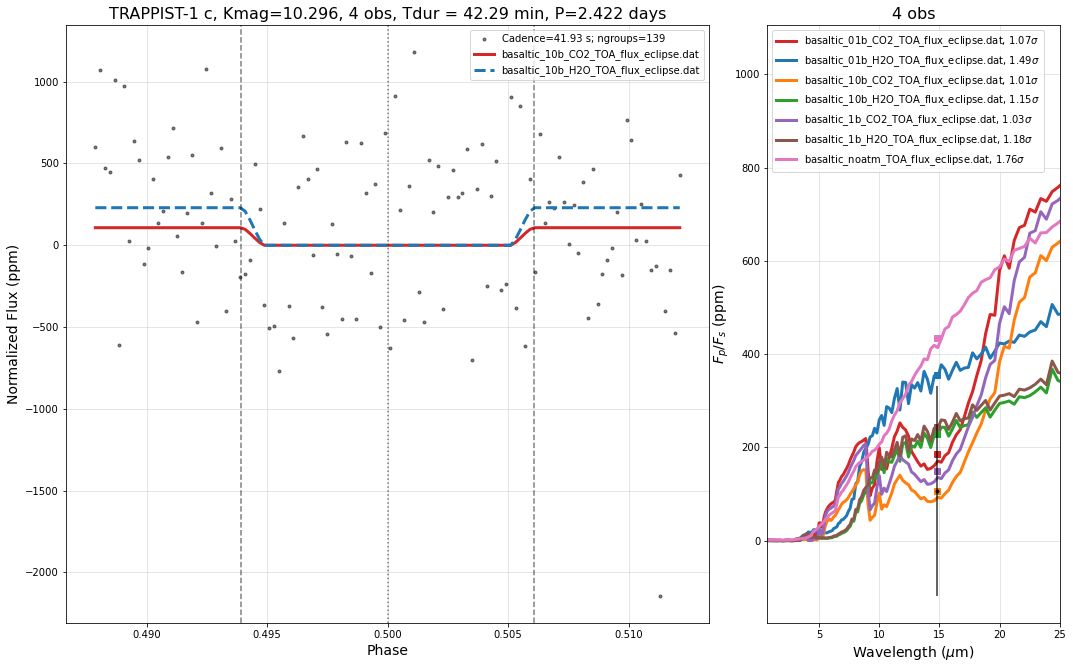

Fp_Fs fraction 0.00036488862536153464
2480.0256 60.0
60.0 60.0
REAL NOISE?? [1455.0928853]
NEW NOISE  [727.54644265]


In [15]:
T1 = ascii.read('/home/hannah/Research/Proposals/Telescope/JWST/Cycle03/AlexAndLars_TRAPPIST-1efg/NASAExoArchive_TransitingExoplanetSystem_TRAPPIST-1.dat')
print("number of planets", len(T1))
# fix nobs:
T1['nobs']     = [4 for i in T1]
T1['subarray'] = ['full' for i in T1]
T1['frac_fullwell'] = [0.65 for i in T1]
T1['ngroup']   = [12 for i in T1]
T1

targ = T1[1]
starname = targ['hostname'].replace(' ', '')
starname = targ['hostname'].replace(' ', '')
input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
input_spec = ascii.read(input_spec_path)
input_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])
targ['ngroup'] = process_target(targ, Fp_Fs_from_model=True, Albedos=[], display_figure=True, 
               stellar_spec='input', input_spec=input_spec)

hostname  pl_name  sy_dist    rastr         decstr    sy_kmag  sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum    pl_tranmid    pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2     pl_orbper     pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag      pl_rp_rs             pl_g            pl_teq_a0            pl_s            pl_rho      filter subarray nobs frac_fullwell ngroup
-------- --------- ------- ------------ ------------- -------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ---------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ----------------- -------------- --------------- ---------- -------------- -------------- ---------- ----------- --------------- -----------

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 61.0
ETC Warnings:
{}
number of groups per integration (ngroup) 39
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 11.681280000000001 s
cadence (integration time plus reset): 11.9808 s
number of in-occultation integrations: 283.0
observing efficiency (%): 97.50000000000001
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
GJ 3473 b --> GJ3473b
TEST signal [227.43083571]
Computing background
Using existing background
[0.0009236]
0.0009235970411251329
TEST 38.82167927307434
TEST [220.68127869]
??? [220.68127869]
DEBUG
   [1.08816127e-17] erg / (Angstrom cm2 s)
   [5.02511266e-21] erg / (Angstrom cm2 s)
   [1.0051108e-20] erg / (Angstrom cm2 s)
[7.14483885e-05] 1000
Data point: 235.59157142857143 +/- [71.44838848] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.08014136195251

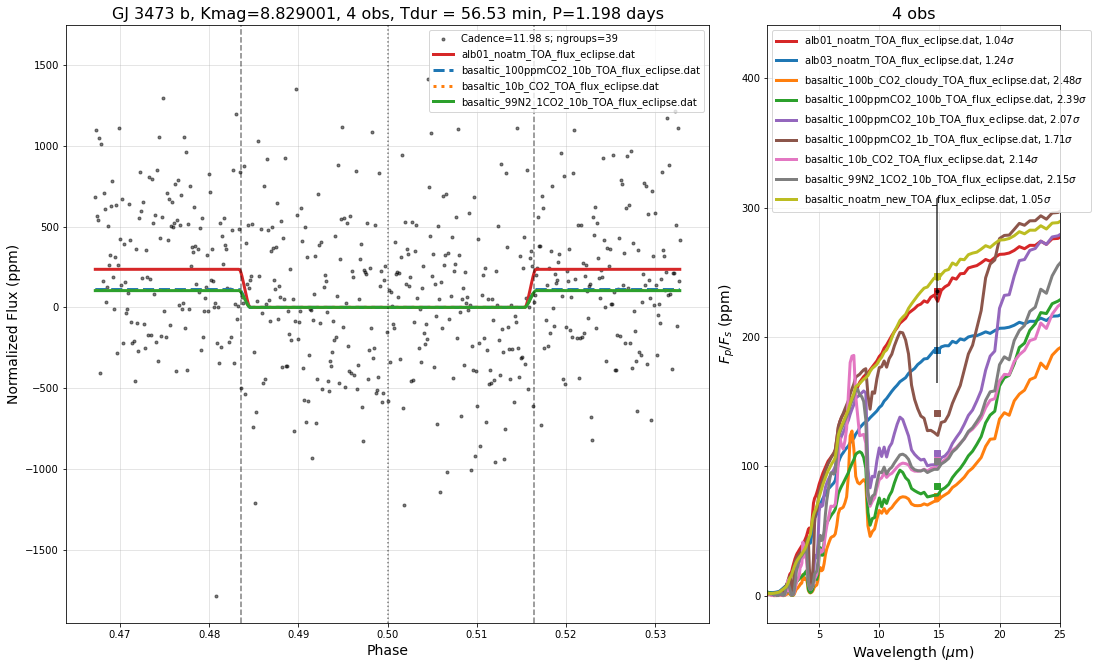

Fp_Fs fraction 0.00019810186090627257
3221.03808 283.0
283.0 283.0
REAL NOISE?? [1306.16346173]
NEW NOISE  [653.08173086]
hostname pl_name  sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum     pl_tranmid    pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2     pl_orbper      pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g            pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup
-------- -------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ----------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ---------------

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 27.0
ETC Warnings:
{}
number of groups per integration (ngroup) 22
time to take one frame (tframe) 0.08512 s
time per single integration (tframe*ngroup): 1.87264 s
cadence (integration time plus reset): 1.9577600000000002 s
number of in-occultation integrations: 2391.0
observing efficiency (%): 95.65217391304347
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
GJ 357 b --> GJ357b
TEST signal [111.36485833]
Computing background
Using existing background
[0.00071563]
0.0007156251720277733
TEST 20.697162916030656
TEST [23.52884406]
??? [23.52884406]
DEBUG
   [9.06334507e-17] erg / (Angstrom cm2 s)
   [6.48595788e-20] erg / (Angstrom cm2 s)
   [6.48630594e-20] erg / (Angstrom cm2 s)
[2.82556879e-05] 1000
Data point: 112.4695 +/- [28.25568791] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0175469645633797
    sig

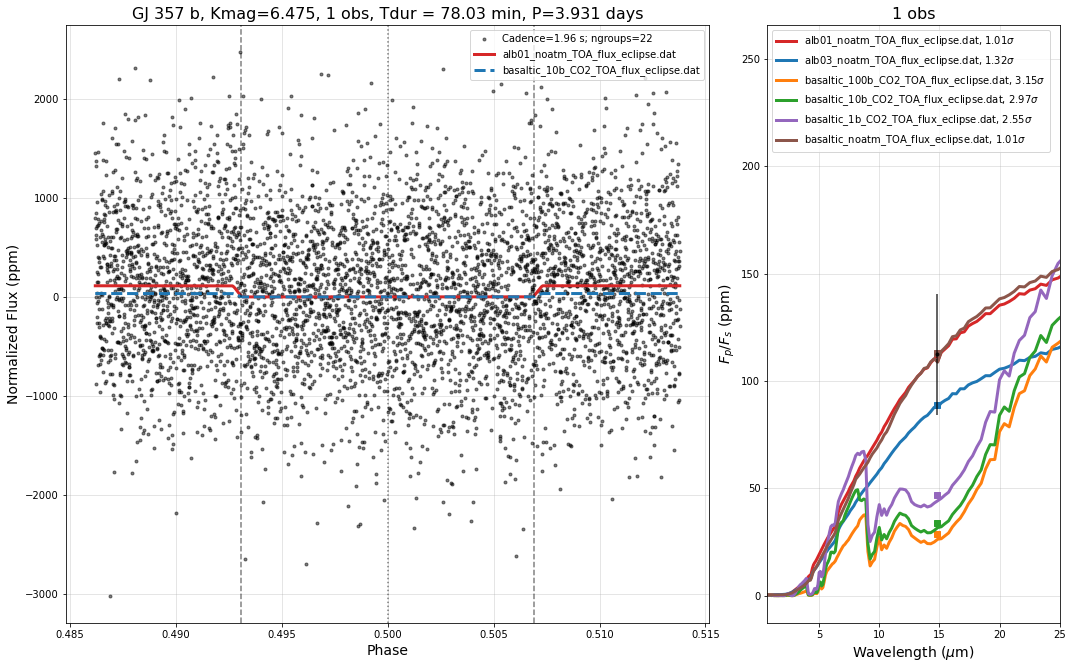

Fp_Fs fraction 9.578307592048588e-05
4273.96032 2391.0
2391.0 2391.0
REAL NOISE?? [1012.04682386]
NEW NOISE  [1012.04682386]
 hostname   pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum  pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag       pl_rp_rs             pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup
--------- ----------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------ -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ----

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 17.0
ETC Warnings:
{}
number of groups per integration (ngroup) 16
time to take one frame (tframe) 0.08512 s
time per single integration (tframe*ngroup): 1.36192 s
cadence (integration time plus reset): 1.44704 s
number of in-occultation integrations: 2869.0
observing efficiency (%): 94.11764705882352
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
HD 260655 b --> HD260655b
TEST signal [75.00741252]
Computing background
Using existing background
[0.00066313]
0.0006631310002212824
TEST 12.380382331027521
TEST [10.17392914]
??? [10.17392914]
DEBUG
   [1.46014569e-16] erg / (Angstrom cm2 s)
   [6.8466878e-20] erg / (Angstrom cm2 s)
   [9.68302798e-20] erg / (Angstrom cm2 s)
[1.62840344e-05] 1000
Data point: 77.02022142857143 +/- [16.2840344] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 0.9666445998849761
    si

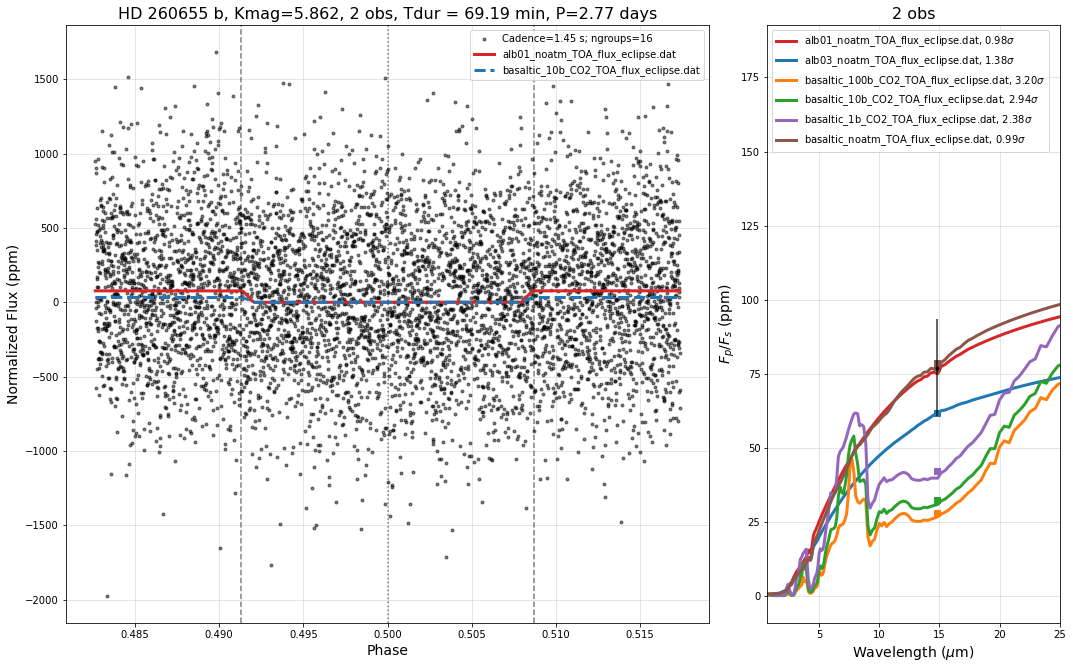

Fp_Fs fraction 9.7406501631518e-05
3663.1391999999996 2869.0
2869.0 2869.0
REAL NOISE?? [937.80885414]
NEW NOISE  [663.13100022]
hostname  pl_name  sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum  pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag      pl_rp_rs             pl_g           pl_teq_a0             pl_s              pl_rho       filter subarray nobs frac_fullwell ngroup
-------- --------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------ -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- -----

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 34.0
ETC Warnings:
{}
number of groups per integration (ngroup) 23
time to take one frame (tframe) 0.11904 s
time per single integration (tframe*ngroup): 2.7379200000000004 s
cadence (integration time plus reset): 2.8569600000000004 s
number of in-occultation integrations: 1204.0
observing efficiency (%): 95.83333333333334
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
L 98-59 c --> L9859c
TEST signal [168.95182352]
Computing background
Using existing background
[0.00079159]
0.0007915901966177371
TEST 32.262807840242175
TEST [52.89477281]
??? [52.89477281]
DEBUG
   [5.13615471e-17] erg / (Angstrom cm2 s)
   [4.06572971e-20] erg / (Angstrom cm2 s)
   [4.06605616e-20] erg / (Angstrom cm2 s)
[4.62368777e-05] 1000
Data point: 170.67085714285713 +/- [46.23687771] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.06

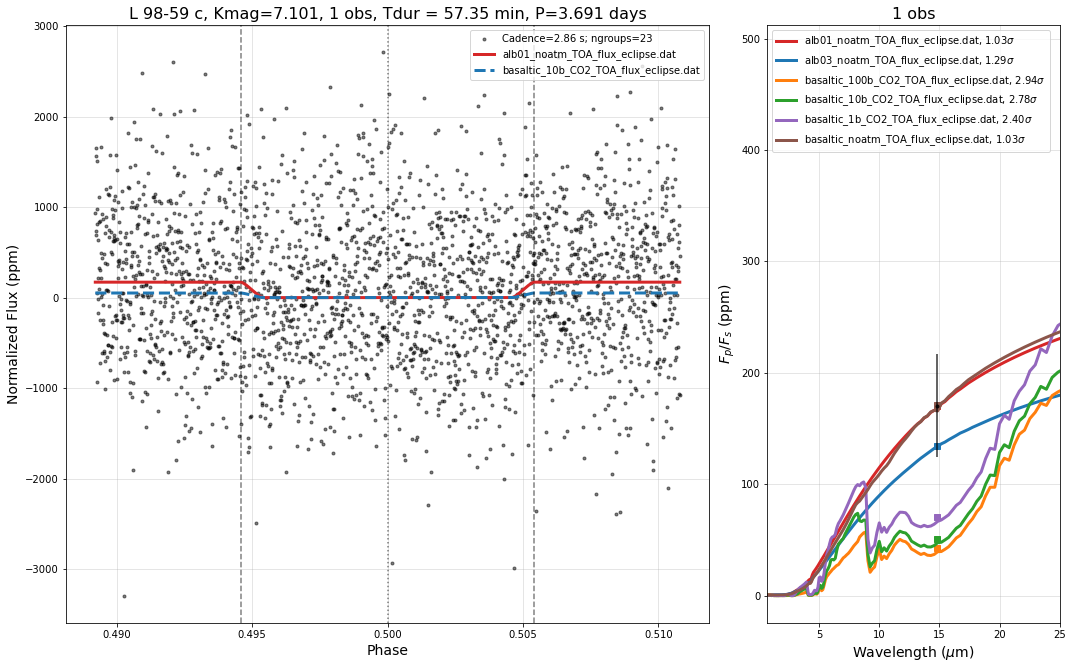

Fp_Fs fraction 0.00014547157654880272
3153.1315200000004 1204.0
1204.0 1204.0
REAL NOISE?? [1119.4775919]
NEW NOISE  [1119.4775919]
hostname  pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag  st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum    pl_tranmid   pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2  pl_orbper  pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag       pl_rp_rs             pl_g            pl_teq_a0             pl_s             pl_rho      filter subarray nobs frac_fullwell ngroup
-------- ---------- ------- ------------ ------------- ------- -------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ --------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- -----------

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 56.0
ETC Warnings:
{}
number of groups per integration (ngroup) 36
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 10.782720000000001 s
cadence (integration time plus reset): 11.08224 s
number of in-occultation integrations: 372.0
observing efficiency (%): 97.2972972972973
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
LHS 1140 c --> LHS1140c
TEST signal [181.2629119]
Computing background
Using existing background
[0.00089321]
0.0008932117902774072
TEST 37.81267026776609
TEST [207.71339548]
??? [207.71339548]
DEBUG
   [1.20396387e-17] erg / (Angstrom cm2 s)
   [6.20879432e-21] erg / (Angstrom cm2 s)
   [1.07547349e-20] erg / (Angstrom cm2 s)
[6.84691743e-05] 1000
Data point: 183.08378571428568 +/- [68.46917426] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.06320167719

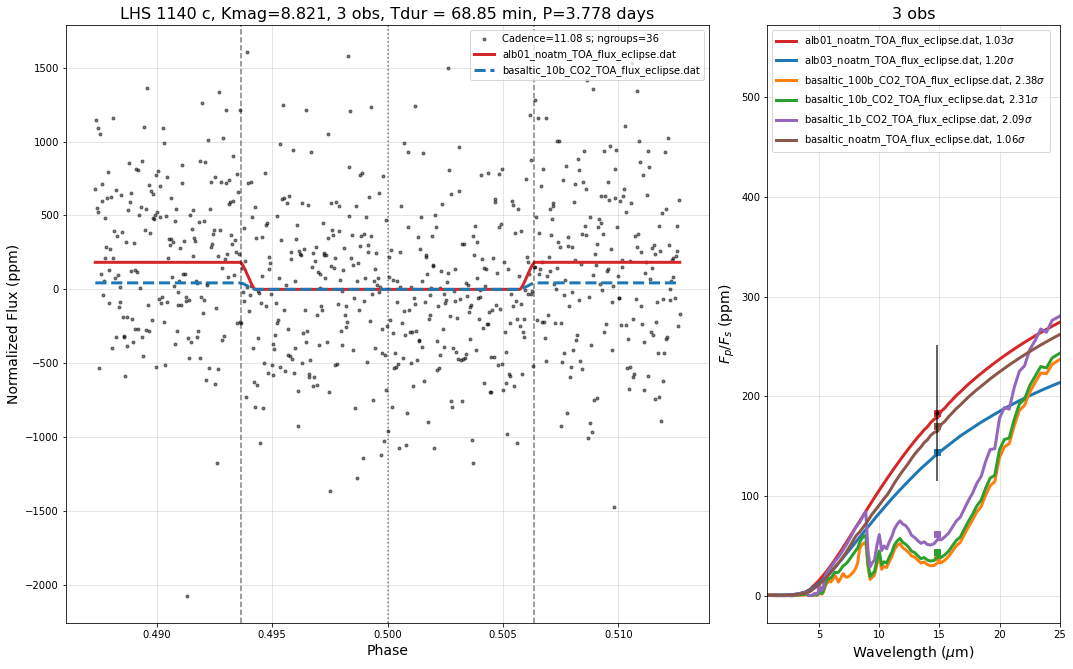

Fp_Fs fraction 0.00019768187711188703
3899.7504 372.0
372.0 372.0
REAL NOISE?? [1263.19222788]
NEW NOISE  [729.30437281]
hostname  pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g            pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup
-------- ---------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- --------

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 60.0
ETC Warnings:
{}
number of groups per integration (ngroup) 39
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 11.681280000000001 s
cadence (integration time plus reset): 11.9808 s
number of in-occultation integrations: 217.0
observing efficiency (%): 97.50000000000001
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
LHS 1478 b --> LHS1478b
TEST signal [297.32452023]
Computing background
Using existing background
[0.00087047]
0.000870467146230776
TEST 41.78376012079509
TEST [257.47687787]
??? [257.47687787]
DEBUG
   [1.13009258e-17] erg / (Angstrom cm2 s)
   [4.9185423e-21] erg / (Angstrom cm2 s)
   [9.83830874e-21] erg / (Angstrom cm2 s)
[7.76782578e-05] 1000
Data point: 301.31557142857145 +/- [77.67825783] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.075834217487

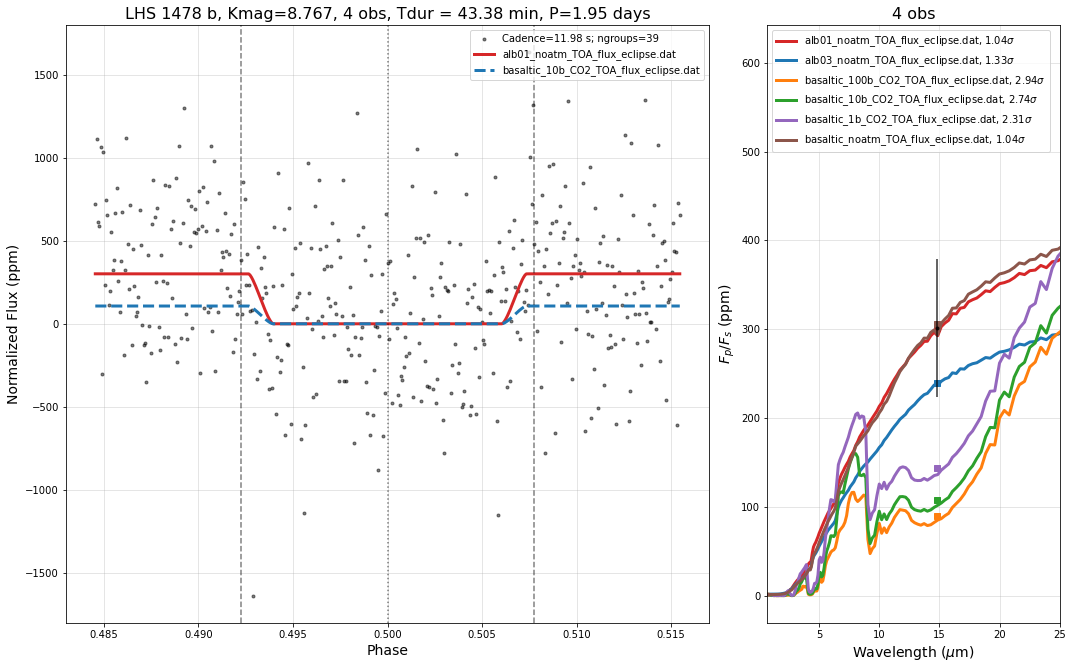

Fp_Fs fraction 0.0002582700132482544
2469.84192 217.0
217.0 217.0
REAL NOISE?? [1231.0264438]
NEW NOISE  [615.5132219]
hostname  pl_name   sy_dist    rastr         decstr    sy_kmag  sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup
-------- ---------- ------- ------------ ------------- -------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ---------

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 35.0
ETC Warnings:
{}
number of groups per integration (ngroup) 22
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 6.58944 s
cadence (integration time plus reset): 6.88896 s
number of in-occultation integrations: 412.0
observing efficiency (%): 95.65217391304347
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
LTT 3780 b --> LTT3780b
TEST signal [290.1687116]
Computing background
Using existing background
[0.00086964]
0.0008696383561901593
TEST 42.84400668844161
TEST [153.81284519]
??? [153.81284519]
DEBUG
   [1.94343315e-17] erg / (Angstrom cm2 s)
   [1.19506986e-20] erg / (Angstrom cm2 s)
   [1.6902964e-20] erg / (Angstrom cm2 s)
[7.00242465e-05] 1000
Data point: 309.2284285714286 +/- [70.02424653] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.065070235899489
    sigm

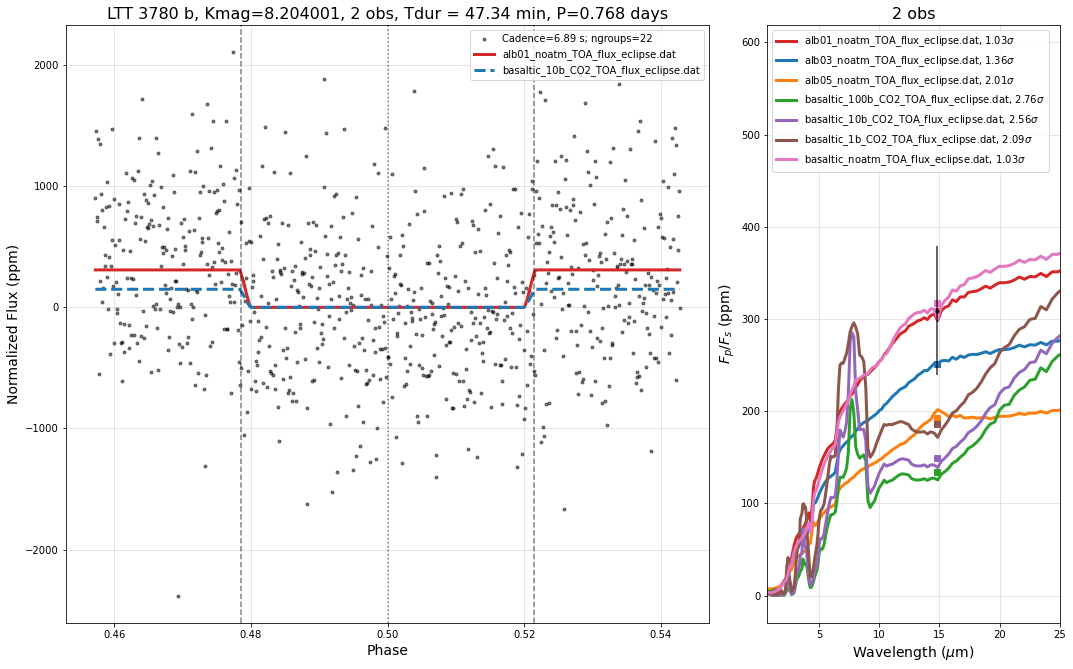

Fp_Fs fraction 0.0002507120061486788
2591.44704 412.0
412.0 412.0
REAL NOISE?? [1229.85435768]
NEW NOISE  [869.63835619]
hostname  pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag       pl_rp_rs             pl_g            pl_teq_a0            pl_s             pl_rho      filter subarray nobs frac_fullwell ngroup
-------- ---------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ----------

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 48.0
ETC Warnings:
{}
number of groups per integration (ngroup) 31
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 9.285120000000001 s
cadence (integration time plus reset): 9.58464 s
number of in-occultation integrations: 394.0
observing efficiency (%): 96.87500000000001
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
TOI-1468 b --> TOI1468b
TEST signal [192.36029024]
Computing background
Using existing background
[0.00088178]
0.0008817789722733836
TEST 36.271540211935196
TEST [175.42605961]
??? [175.42605961]
DEBUG
   [1.40314295e-17] erg / (Angstrom cm2 s)
   [7.14333519e-21] erg / (Angstrom cm2 s)
   [1.23736034e-20] erg / (Angstrom cm2 s)
[6.34610811e-05] 1000
Data point: 196.234 +/- [63.46108111] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0588693361904389
    

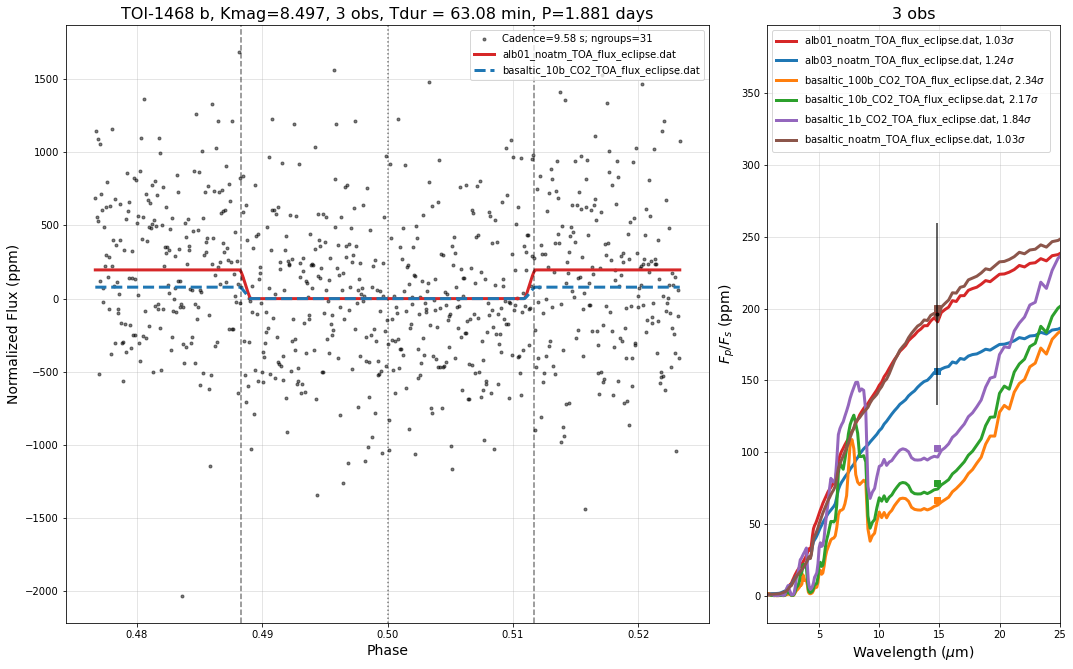

Fp_Fs fraction 0.000176582218648705
3540.3264 394.0
394.0 394.0
REAL NOISE?? [1247.0237816]
NEW NOISE  [719.969516]
hostname  pl_name  sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 pl_ratror pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup
-------- --------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- --

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:1012: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroups for saturation: 39.0
ETC Warnings:
{}
number of groups per integration (ngroup) 25
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 7.488 s
cadence (integration time plus reset): 7.787520000000001 s
number of in-occultation integrations: 663.0
observing efficiency (%): 96.15384615384616
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
TOI-270 b --> TOI270b
TEST signal [104.83291566]
Computing background
Using existing background
[0.00084949]
0.000849490915999395
TEST 23.328508707716647
TEST [97.01487122]
??? [97.01487122]
DEBUG
   [1.75825027e-17] erg / (Angstrom cm2 s)
   [7.46808816e-21] erg / (Angstrom cm2 s)
   [1.4936867e-20] erg / (Angstrom cm2 s)
[3.92058591e-05] 1000
Data point: 106.13810714285715 +/- [39.20585907] ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.004207614068382
  

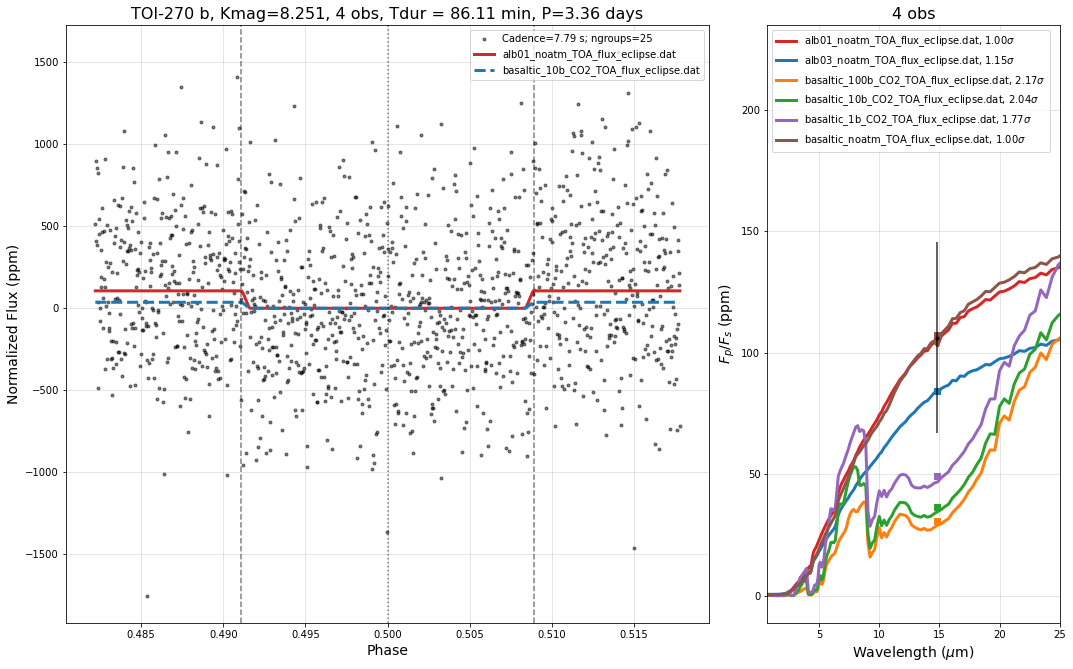

Fp_Fs fraction 9.605951507708886e-05
4765.96224 663.0
663.0 663.0
REAL NOISE?? [1201.36157452]
NEW NOISE  [600.68078726]


In [396]:
%matplotlib inline
for targ in sample:
    starname = targ['hostname'].replace(' ', '')
    starname = targ['hostname'].replace(' ', '')
    input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
    input_spec = ascii.read(input_spec_path)
    input_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])
    targ['ngroup'] = process_target(targ, Fp_Fs_from_model=True, Albedos=[], display_figure=True, 
                   stellar_spec='input', input_spec=input_spec)

In [ ]:
ascii.write(sample, 'sample_final.csv', overwrite=True)

In [194]:
sample['hostname', 'pl_name', 'subarray', 'ngroup', 'frac_fullwell']

hostname,pl_name,subarray,ngroup,frac_fullwell
str9,str11,str6,int64,float64
GJ 3473,GJ 3473 b,sub256,39,0.65
GJ 357,GJ 357 b,sub64,22,0.85
HD 260655,HD 260655 b,sub64,16,0.95
L 98-59,L 98-59 c,sub128,23,0.7
LHS 1140,LHS 1140 c,sub256,36,0.65
LHS 1478,LHS 1478 b,sub256,39,0.65
LTT 3780,LTT 3780 b,sub256,22,0.65
TOI-1468,TOI-1468 b,sub256,31,0.65
TOI-270,TOI-270 b,sub256,25,0.65


In [17]:
#i = 9
#process_target(sample[i-1], Fp_Fs_from_model=True, Albedos=[0.1, 0.2], display_figure=True, save_figure=False)

Approximate observing time per eclipse observation: 3.440893972850165 h
Creating MIRI dictionary
Computing background
Using existing background
Returning MIRI dictionary


/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ETC Warnings:
{}
number of groups per integration 7
time per single integration: 19.42528 s
cadence (integration time plus reset): 22.20032 s
number of in-occultation integrations: 152.78399341931538
observing efficiency (%): 87.5
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{}
GJ 3473 b --> GJ3473b
points binned to 8.822681918550508 min
Data point: 235.99800000000005 +/- 31.008107850467276 ppm
0
    chisq_red 0.939927750981612
    sigma 0.9694987111810012
1
    chisq_red 8.885909625477783
    sigma 2.9809242904639133
2
    chisq_red 18.386022961998414
    sigma 4.287892601499997


(0.0, 300.0)

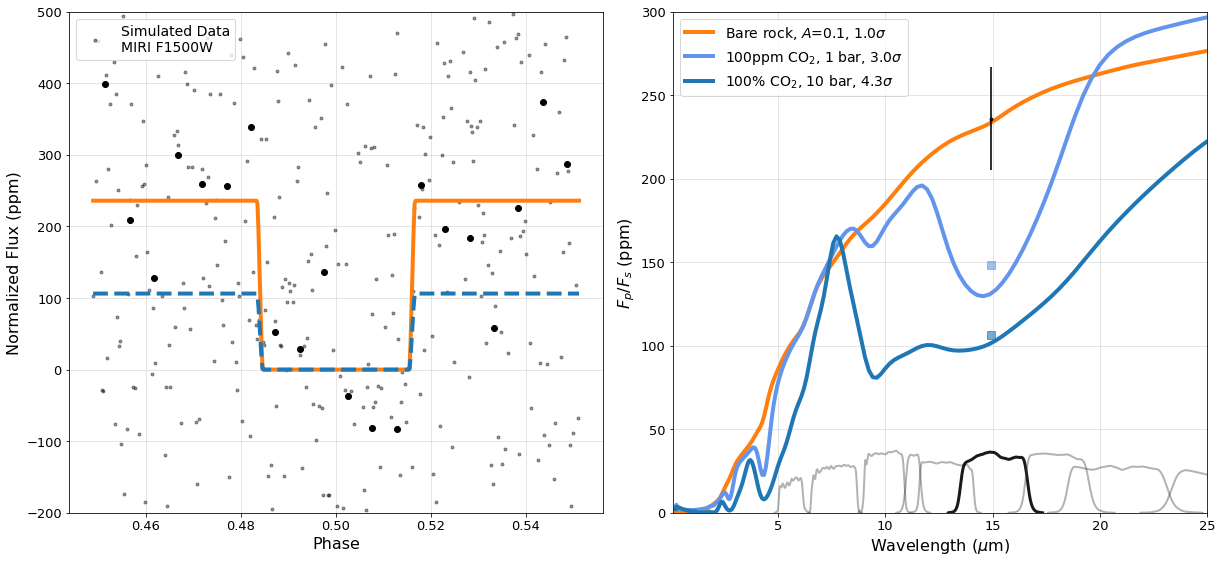

In [18]:
%matplotlib inline
from astropy.convolution import Gaussian1DKernel, convolve

targ = sample[0]
ndraws = 1000
filter = targ['filter']
subarray = targ['subarray']
nobs = targ['nobs']

# star_params
star_name = targ['hostname']
k_mag = targ['sy_kmag']

# planet params
tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
                a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
                i = targ['pl_orbincl']
               ) # event duration

# obs params
tfrac   = 1.06      # how many times occuldation duration to observe
tsettle = 30 * u.min    # should be specific to MIRI
tcharge = 1 * u.hr      # amount of charged time becuase JWST will not start observations right away
noccultations = 1       # can always scale later
mingroups = 5           # suggested for MIRI Imaging TSO
expfact_out = 1         # bare minimum of out-of-transit baseline; but will be asking for more so not a big deal


approx_obs_time = (tdur + tfrac*tdur + tsettle + tcharge).to(u.hr)
print('Approximate observing time per eclipse observation:', approx_obs_time)

# make the pandeia-2.0 dictionary for miri
miri_imaging_ts = make_miri_dict(filter, subarray, targ)

report = perform_calculation(miri_imaging_ts)
ngroup = int(report['scalar']['sat_ngroups'])  # use as many groups as possible without saturating
if ngroup > 300: ngroup = 300        # ngroups > 300 not recommended due to cosmic rays
miri_imaging_ts['configuration']['detector']['ngroup'] = ngroup

report = perform_calculation(miri_imaging_ts)

print('ETC Warnings:')
print(report['warnings']) # should be empty if nothing is wrong

tframe  = report['information']['exposure_specification']['tframe'] * u.s
tint    = tframe * ngroup                         # amount of time per integration
treset  = 1*tframe                                # reset time between each integration
cadence = tint + treset
nint    = (tdur/(tint + treset)).decompose()      # number of in-transit integrations
ref_wave = report['scalar']['reference_wavelength']                         * u.micron

print('number of groups per integration', ngroup)
print('time per single integration:', tint)
print('cadence (integration time plus reset):', cadence)
print('number of in-occultation integrations:', nint.decompose())
print('observing efficiency (%):', (tint/cadence).decompose()*100)

# the wavelength and throughput of the designated filter
bandpass_wave = report['1d']['fp'][0]
bandpass_flux = report['1d']['fp'][1]

# make a special dictionary, based off of the first MIRI dictionary, to get flux in useful units
miri_imaging_ts_calibration = make_miri_calib_dict(miri_imaging_ts)
report_calibration = perform_calculation(miri_imaging_ts_calibration)
print('Calibartion Warnings:')
print(report_calibration['warnings']) #should be empty if nothing is wrong

# compute uncertainty in a single measurement
snr = report['scalar']['sn']
extracted_flux = report['scalar']['extracted_flux'] / u.s
extracted_noise = report['scalar']['extracted_noise'] / u.s

calibration_extracted_flux = report_calibration['scalar']['extracted_flux'] / u.s
calibration_norm_value = report_calibration['input']['scene'][0]['spectrum']['normalization']['norm_flux']

signal = extracted_flux / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA
noise  = extracted_noise / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA

noise /= np.sqrt(nobs)

tstart = (targ['pl_orbper']*u.day)*0.5 - (tdur/2) - (tdur*tfrac/2) - tcharge/2
tend   = (targ['pl_orbper']*u.day)*0.5 + (tdur/2) + (tdur*tfrac/2) + tcharge/2
trange = tend - tstart
total_int = int(np.ceil((trange/cadence).decompose()))

signal_ts = np.ones(total_int)*signal
np.random.seed(32)
scatter_ts = np.random.normal(0, noise.value, total_int) * u.erg/u.s/u.cm**2/u.AA
signal_ts_scatter = signal_ts.value + scatter_ts.value


# now get some model atmospehres
#all_spec = get_all_model_spec(targ)
#for model in all_spec.keys():
#    wave = all_spec[model][0]
#    fpfs = all_spec[model][1]

#    bandpass_inds = (wave>bandpass_wave[0]) * (wave<bandpass_wave[-1])
#    model_binned_to_bandpass = np.mean(fpfs[bandpass_inds])

#    models[model] = {}
#    models[model]['wave'] = wave
#    models[model]['fpfs'] = fpfs
#    models[model]['wave_band'] = ref_wave
#    models[model]['fpfs_band'] = model_binned_to_bandpass

plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
print(targ['pl_name'], '-->', plnt_name)
models = {}
alb01         = '../JWST_Terrestrials/'+plnt_name+'/Spectra/alb01_noatm_TOA_flux_eclipse.dat'
CO2_10b       = '../JWST_Terrestrials/'+plnt_name+'/Spectra/basaltic_10b_CO2_TOA_flux_eclipse.dat'
CO2_100ppm_1b = '../JWST_Terrestrials/'+plnt_name+'/Spectra/basaltic_100ppmCO2_1b_TOA_flux_eclipse.dat'
labels = ['Bare rock, $A$=0.1', '100ppm CO$_2$, 1 bar', '100% CO$_2$, 10 bar']

paths = [alb01, CO2_100ppm_1b, CO2_10b]

for m, path in enumerate(paths):
    model = ascii.read(path, data_start=3)
    
    wave = model['col2']
    fpfs = model['col7']
    
    bandpass_inds = (wave>bandpass_wave[0]) * (wave<bandpass_wave[-1])
    model_binned_to_bandpass = np.mean(fpfs[bandpass_inds])
    
    models[m] = {}
    models[m]['wave'] = wave
    models[m]['fpfs'] = fpfs
    models[m]['wave_band'] = ref_wave
    models[m]['fpfs_band'] = model_binned_to_bandpass

# use stary to make the system; 
# but be careful, this is just the basis; need to set the planet amplitude for each case
star = make_star(targ)

# create light curve time points (will use to compute fluxes)
time = np.linspace(tstart.value, tend.value, total_int) # times in... days?

def get_binned_signal(flux):       
    signal_ts_scatter_binned, time_bin_edges, _ = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                         bins=20)
    time_bin_width = np.mean(np.diff(time_bin_edges))
    time_binned = time_bin_edges[:-1] + time_bin_width/2

    return time_binned, signal_ts_scatter_binned

fig = plt.figure(figsize=(17,8))
gs = gridspec.GridSpec(1, 2, left=0.06, right=0.99, bottom=0.1, top=0.97, wspace=0.13)

figure = {}
figure['lc'] = fig.add_subplot(gs[0,0])
figure['FpFs'] = fig.add_subplot(gs[0,1])

yerr = 1/report['scalar']['sn'] / np.sqrt(nint) / np.sqrt(nobs)

# based on Joao's model names
line_styles = ['-', ':', '--']
colors = ['tab:orange', 'cornflowerblue', 'C0', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

draw_eclipse_depth_bare_rock = np.random.normal(models[0]['fpfs_band'], yerr, ndraws)
dof = 1  # rough estimate; only 1 data point

for i, case in enumerate(models):
    if i==0: planet = make_planet(targ, tidally_locked=False)
    else: planet = make_planet(targ, tidally_locked=False)
    planet.map.amp = models[case]['fpfs_band']
    system = st.System(star, planet)
    flux = np.hstack(system.flux(time))
    time_binned, signal_ts_scatter_binned = get_binned_signal(flux)

    if i==0: 
        print('points binned to', np.mean(np.diff(time_binned))*24*60, 'min')
        figure['lc'].plot(time/targ['pl_orbper'], 
                         ((signal_ts_scatter*flux/signal).value -1)*1e6, 
                          '.', color='k', alpha=0.4, 
                          label='Simulated Data\nMIRI F1500W')
        figure['lc'].plot(time_binned/targ['pl_orbper'], 
                          ((signal_ts_scatter_binned/signal).value -1)*1e6, 
                          'o', markersize=6, color='k', alpha=1)

        # only plot error bar for bare rock case in Fp/Fs figure
        figure['FpFs'].errorbar(models[case]['wave_band'].value, models[case]['fpfs_band'] *1e6, 
                                yerr=yerr.value *1e6, fmt='.', color='k', elinewidth=2,
                                alpha=0.8, zorder=1000)
        print('Data point:', models[case]['fpfs_band']*1e6, '+/-', yerr*1e6, 'ppm')

    if i==0 or i==2: figure['lc'].plot(time/targ['pl_orbper'], ((signal_ts*flux/signal).value -1)*1e6, 
                      ls=line_styles[i%3], lw=4, color=colors[i])

g = Gaussian1DKernel(stddev=2)
for i, model in enumerate(models):
    print(model)

    chisq = calc_chi_sq(models[model]['fpfs_band'], draw_eclipse_depth_bare_rock, yerr) / ndraws # can do this trick since only 1 data point
    print('    chisq_red', chisq)
    sigma = calc_significance(chisq, dof)
    print('    sigma', sigma)

    z = convolve(models[model]['fpfs'], g)
    figure['FpFs'].plot(models[model]['wave'], z *1e6, lw=4, color=colors[i], 
                        label=f'{labels[i]}, {sigma:.1f}$\sigma$')
    if i!=0: figure['FpFs'].plot(models[model]['wave_band'], models[model]['fpfs_band']*1e6, 
                                's', markersize=8, color=colors[i], alpha=0.6)

wave_filter = np.linspace(0, 25, 10000)
conf= {
    "detector": {
        "nexp": 1,
        "ngroup": 10,
        "nint": 1,
        "readout_pattern": "fastr1",
        "subarray": "full"
    },
    "instrument": {
        "aperture": "imager",
        "filter": "f1800w",
        "instrument": "miri",
        "mode": "imaging"
    },
}
for f in ['f560w', 'f770w', 'f1000w', 'f1130w', 'f1280w', 'f1500w', 'f1800w', 'f2100w', 'f2550w']:
    conf["instrument"]["filter"] = f
    # create a configured instrument
    instrument_factory = InstrumentFactory(config=conf)
    # get the throughput of the instrument over the desired wavelength range
    eff = instrument_factory.get_total_eff(wave_filter)
    inds0 = eff>0
    wv, eff = wave_filter[inds0], eff[inds0]
    
    if f=='f1500w': color, lw, alpha = 'k', 3, 0.9
    else: color, lw, alpha ='#404040', 2, 0.4
    plt.plot(wv, eff*75, color=color, ls='-', lw=lw, alpha=alpha)

figure['lc'].legend(loc='upper left', fontsize=14)
per = targ['pl_orbper']
#figure['lc'].set_title(targ['pl_name']+f', Kmag={k_mag}, {nobs} obs, Tdur = {np.round(tdur.to(u.min), 2)}, P={np.round(per, 3)} days', fontsize=16)

figure['lc'].set_xlabel('Phase', fontsize=16)
figure['lc'].set_ylabel('Normalized Flux (ppm)', fontsize=16)
figure['lc'].tick_params(which='both', labelsize=13)
figure['lc'].set_ylim(0.-200, 500)
figure['lc'].grid(alpha=0.4)

figure['FpFs'].legend(loc='upper left', fontsize=14)
figure['FpFs'].set_ylabel('$F_p$/$F_s$ (ppm)', fontsize=16)
figure['FpFs'].set_xlabel('Wavelength ($\mu$m)', fontsize=16)
figure['FpFs'].tick_params(which='both', labelsize=13)
#Fp_Fs_from_model: figure['FpFs'].set_title(f'{nobs} obs', fontsize=16)
figure['FpFs'].set_xlim(0.1, 25)
figure['FpFs'].grid(alpha=0.4)
figure['FpFs'].set_ylim(0, 300)

#plt.savefig('../Figure_MockData_FpFsModels.png', dpi=200, facecolor='white')

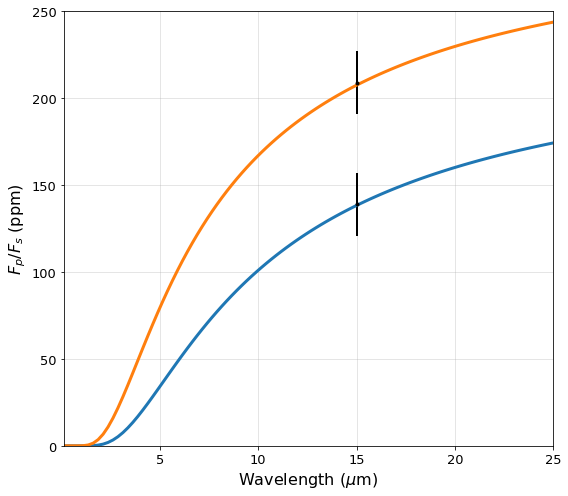

In [16]:
targ = sample[0]
wave = np.linspace(0.1, 25, 100) * u.micron
T_rock = calc_Tday(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, atmo='bare_rock')
T_atmo = calc_Tday(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, atmo='equilibrium')

FpFs_rock = calc_FpFs(targ['st_teff']*u.K, T_rock, wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)
FpFs_atmo = calc_FpFs(targ['st_teff']*u.K, T_atmo, wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)


plt.figure(figsize=(8, 7))
plt.plot(wave, FpFs_atmo*1e6, color='C0', lw=3)
plt.plot(wave, FpFs_rock*1e6, color='tab:orange', lw=3)

plt.errorbar(15, 208.998, yerr=18, fmt='.', color='k', elinewidth=2)
plt.errorbar(15, 138.998, yerr=18, fmt='.', color='k', elinewidth=2)

plt.xlim(0.1, 25)
plt.ylim(0, 250)

plt.ylabel('$F_p$/$F_s$ (ppm)', fontsize=16)
plt.xlabel('Wavelength ($\mu$m)', fontsize=16)

plt.tick_params(which='both', labelsize=13)

plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('../Figure_Trock_Tday_Basic', dpi=200)

In [ ]:
targ['st_teff']*u.K

In [34]:
T1 = genSys.generateTransitingExoSystem(hostname="TRAPPIST-1")
T1.add_column('f1500w', name='filter')
T1.add_column('full', name='subarray')
T1.add_column(1, name='nobs')

Accessing NASA Exoplanet Archive
Table of transiting exoplanets retrieved
Writing table to ./NASAExoArchive_TransitingExoplanetSystem_TRAPPIST-1.dat


In [35]:
T1b = T1[0]
pull_default_dict = True # needs to be true if you want to pull a new default dictionary from pandeia
make_new_bkg      = True # should be true if working with different stars; otherwise set to False for speed

 hostname    pl_name     sy_dist   sy_disterr1 sy_disterr2    rastr         decstr    sy_kmag st_mass st_masserr1 st_masserr2 st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2   pl_tranmid   pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag filter subarray nobs
                            pc          pc          pc         deg           deg        mag     Msun      Msun        Msun     Rsun     Rsun       Rsun       K         K           K           day            day            day        Rearth    Rearth      Rearth     Mearth      Mearth        Mearth       day         day           day          AU           AU             AU          deg                                                                                       
---------- ------------ ---------- ----------- ---

<ipython-input-39-da9453cde421>:178: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  else: cases = np.hstack(models.keys())


ValueError: need at least one array to concatenate

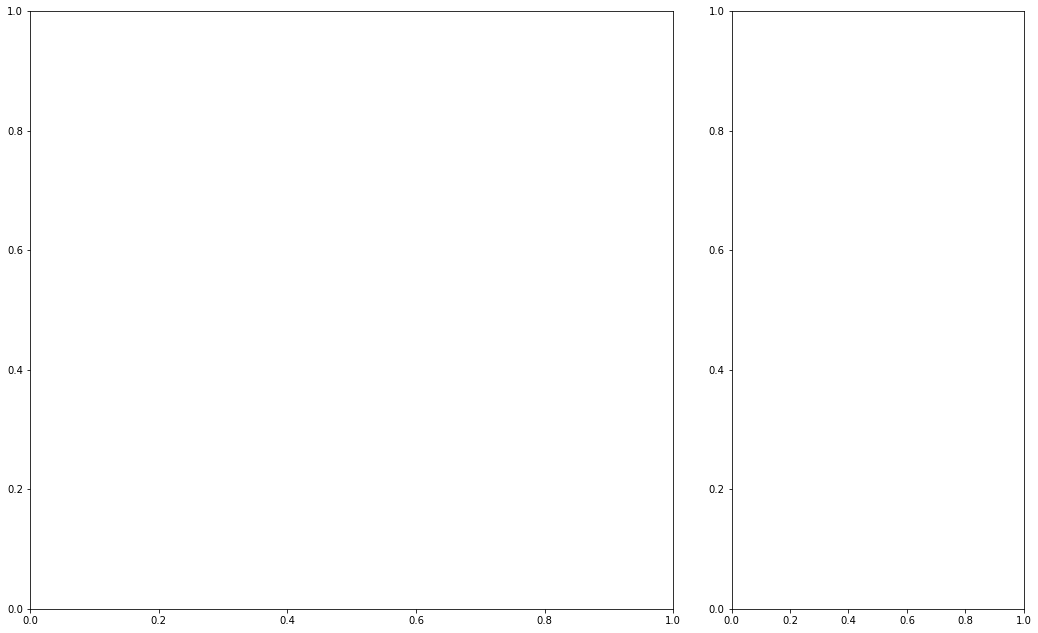

In [40]:
process_target(T1b)

In [44]:
sample['sy_kmag']

8.829001
6.475
5.862
7.101
8.821
8.767
8.204001
8.497
8.251


In [45]:
T1b['sy_kmag']

10.296

In [48]:
256*.11

28.16